In [1]:
from db_con import DatabaseConnection
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.widgets import Slider
import scipy.stats
from matplotlib import ticker
import numpy as np
from matplotlib import rc
#from fitter import get_distributions
import warnings
warnings.filterwarnings("ignore")

from multiprocessing import Pool
import psutil
import os
from sys import platform

In [2]:
# query1 = """SELECT percentile_cont(0.25) WITHIN GROUP (ORDER BY one.avg_v) FROM (SELECT AVG(velo) as avg_v FROM accels a JOIN ride r ON r.filename = a.filename WHERE velo > 0.2 AND velo != 'NaN' AND velo < 15 AND r.bike = 3 GROUP BY a.filename) as one"""
# query2 = """SELECT percentile_cont(0.75) WITHIN GROUP (ORDER BY one.avg_v) FROM (SELECT AVG(velo) as avg_v FROM accels a JOIN ride r ON r.filename = a.filename WHERE velo > 0.2 AND velo != 'NaN' AND velo < 15 AND r.bike = 3 GROUP BY a.filename) as one"""

with DatabaseConnection() as cur:
    cur.execute(f"""
        SELECT two.filename, two.avg_v, two.max_v, one.accel, one.decel FROM (
                SELECT filename, MAX(accel) as accel, MIN(accel) as decel FROM accels GROUP BY filename
            ) as one JOIN (
                SELECT filename, SUM(velo * duration)/SUM(duration) as avg_v, MAX(velo) as max_v FROM accels WHERE velo > 0.2 AND velo != 'NaN' and velo < 15 GROUP BY filename
            ) as two ON (one.filename = two.filename) JOIN (
                SELECT filename, bike FROM ride WHERE bike = 3
            ) as biketype ON (two.filename = biketype.filename)""")

    objs_eb = cur.fetchall()


In [3]:
query1 = """SELECT percentile_cont(0.25) WITHIN GROUP (ORDER BY one.avg_v) FROM (SELECT AVG(velo) as avg_v FROM accels a JOIN ride r ON r.filename = a.filename WHERE velo > 0.2 AND velo != 'NaN' AND velo < 15 AND r.bike != 0 AND r.bike != 3 GROUP BY a.filename) as one"""
query2 = """SELECT percentile_cont(0.75) WITHIN GROUP (ORDER BY one.avg_v) FROM (SELECT AVG(velo) as avg_v FROM accels a JOIN ride r ON r.filename = a.filename WHERE velo > 0.2 AND velo != 'NaN' AND velo < 15 AND r.bike != 0 AND r.bike != 3 GROUP BY a.filename) as one"""

with DatabaseConnection() as cur:
    cur.execute(f"""
        SELECT two.filename, two.avg_v, two.max_v, one.accel, one.decel, CASE WHEN two.avg_v < ({query1}) THEN 0 ELSE CASE WHEN two.avg_v < ({query2}) THEN 1 ELSE 2 END END as group FROM (
                SELECT filename, MAX(accel) as accel, MIN(accel) as decel FROM accels GROUP BY filename
            ) as one JOIN (
                SELECT filename, SUM(velo * duration)/SUM(duration) as avg_v, MAX(velo) as max_v FROM accels WHERE velo > 0.2 AND velo != 'NaN' and velo < 15 GROUP BY filename
            ) as two ON (one.filename = two.filename) JOIN (
                SELECT filename, bike FROM ride WHERE bike != 0 AND bike != 3
            ) as biketype ON (two.filename = biketype.filename)""")

    objs = cur.fetchall()


In [4]:
query1 = """SELECT percentile_cont(0.25) WITHIN GROUP (ORDER BY one.avg_v) FROM (SELECT AVG(velo) as avg_v FROM accels a JOIN ride r ON r.filename = a.filename WHERE velo > 0.2 AND velo != 'NaN' AND velo < 15 GROUP BY a.filename) as one"""
query2 = """SELECT percentile_cont(0.75) WITHIN GROUP (ORDER BY one.avg_v) FROM (SELECT AVG(velo) as avg_v FROM accels a JOIN ride r ON r.filename = a.filename WHERE velo > 0.2 AND velo != 'NaN' AND velo < 15 GROUP BY a.filename) as one"""

with DatabaseConnection() as cur:
    cur.execute(f"""
        SELECT two.filename, two.avg_v, two.max_v, one.accel, one.decel, CASE WHEN two.avg_v < ({query1}) THEN 0 ELSE CASE WHEN two.avg_v < ({query2}) THEN 1 ELSE 2 END END as group FROM (
                SELECT filename, MAX(accel) as accel, MIN(accel) as decel FROM accels GROUP BY filename
            ) as one JOIN (
                SELECT filename, SUM(velo * duration)/SUM(duration) as avg_v, MAX(velo) as max_v FROM accels WHERE velo > 0.2 AND velo != 'NaN' and velo < 15 GROUP BY filename
            ) as two ON (one.filename = two.filename) JOIN (
                SELECT filename, bike FROM ride
            ) as biketype ON (two.filename = biketype.filename)""")

    objs_everything = cur.fetchall()


In [5]:
pdf_all = pd.DataFrame(objs, columns=['file', 'avg_speed', 'max_speed', 'max_accel', 'max_decel', 'group'])
pdf_eb = pd.DataFrame(objs_eb, columns=['file', 'avg_speed', 'max_speed', 'max_accel', 'max_decel'])
pdf_all_everything = pd.DataFrame(objs_everything, columns=['file', 'avg_speed', 'max_speed', 'max_accel', 'max_decel', 'group'])
print(pdf_all.info)
print(pdf_eb.info)
print(pdf_all_everything.info)

pdf_avg_all = pdf_all[['file', 'avg_speed']].sort_values('avg_speed').reset_index()
pdf_max_all = pdf_all[['file', 'max_speed']].sort_values('max_speed').reset_index()
pdf_acc_all = pdf_all.query('max_accel >= 0.3')[['file', 'max_accel']].sort_values('max_accel').reset_index()
pdf_dec_all = pdf_all.query('max_decel < -0.1')[['file', 'max_decel']].sort_values('max_decel').reset_index()
pdf_dec_all_abs = pdf_dec_all['max_decel'][lambda x: x < 0].abs()

pdf_avg_0 = pdf_all.query('group == 0')[['file', 'avg_speed']].sort_values('avg_speed').reset_index()
pdf_max_0 = pdf_all.query('group == 0')[['file', 'max_speed']].sort_values('max_speed').reset_index()
pdf_acc_0 = pdf_all.query('group == 0 and max_accel >= 0.3')[['file', 'max_accel']].sort_values('max_accel').reset_index()
pdf_dec_0 = pdf_all.query('group == 0 and max_decel < -0.1')[['file', 'max_decel']].sort_values('max_decel').reset_index()
pdf_dec_0_abs = pdf_dec_0['max_decel'][lambda x: x < 0].abs()

pdf_avg_1 = pdf_all.query('group == 1')[['file', 'avg_speed']].sort_values('avg_speed').reset_index()
pdf_max_1 = pdf_all.query('group == 1')[['file', 'max_speed']].sort_values('max_speed').reset_index()
pdf_acc_1 = pdf_all.query('group == 1 and max_accel >= 0.3')[['file', 'max_accel']].sort_values('max_accel').reset_index()
pdf_dec_1 = pdf_all.query('group == 1 and max_decel < -0.1')[['file', 'max_decel']].sort_values('max_decel').reset_index()
pdf_dec_1_abs = pdf_dec_1['max_decel'][lambda x: x < 0].abs()

pdf_avg_2 = pdf_all.query('group == 2')[['file', 'avg_speed']].sort_values('avg_speed').reset_index()
pdf_max_2 = pdf_all.query('group == 2')[['file', 'max_speed']].sort_values('max_speed').reset_index()
pdf_acc_2 = pdf_all.query('group == 2 and max_accel >= 0.3')[['file', 'max_accel']].sort_values('max_accel').reset_index()
pdf_dec_2 = pdf_all.query('group == 2 and max_decel < -0.1')[['file', 'max_decel']].sort_values('max_decel').reset_index()
pdf_dec_2_abs = pdf_dec_2['max_decel'][lambda x: x < 0].abs()

pdf_avg_eb = pdf_eb[['file', 'avg_speed']].sort_values('avg_speed').reset_index()
pdf_max_eb = pdf_eb[['file', 'max_speed']].sort_values('max_speed').reset_index()
pdf_acc_eb = pdf_eb.query('max_accel >= 0.3')[['file', 'max_accel']].sort_values('max_accel').reset_index()
pdf_dec_eb = pdf_eb.query('max_decel < -0.1')[['file', 'max_decel']].sort_values('max_decel').reset_index()
pdf_dec_eb_abs = pdf_dec_eb['max_decel'][lambda x: x < 0].abs()

pdf_avg_all_everything = pdf_all_everything[['file', 'avg_speed']].sort_values('avg_speed').reset_index()
pdf_max_all_everything = pdf_all_everything[['file', 'max_speed']].sort_values('max_speed').reset_index()
pdf_acc_all_everything = pdf_all_everything.query('max_accel >= 0.3')[['file', 'max_accel']].sort_values('max_accel').reset_index()
pdf_dec_all_everything = pdf_all_everything.query('max_decel < -0.1')[['file', 'max_decel']].sort_values('max_decel').reset_index()
pdf_dec_all_everything_abs = pdf_dec_all_everything['max_decel'][lambda x: x < 0].abs()

pdf_avg_0_everything = pdf_all_everything.query('group == 0')[['file', 'avg_speed']].sort_values('avg_speed').reset_index()
pdf_max_0_everything = pdf_all_everything.query('group == 0')[['file', 'max_speed']].sort_values('max_speed').reset_index()
pdf_acc_0_everything = pdf_all_everything.query('group == 0 and max_accel >= 0.3')[['file', 'max_accel']].sort_values('max_accel').reset_index()
pdf_dec_0_everything = pdf_all_everything.query('group == 0 and max_decel < -0.1')[['file', 'max_decel']].sort_values('max_decel').reset_index()
pdf_dec_0_everything_abs = pdf_dec_0_everything['max_decel'][lambda x: x < 0].abs()

pdf_avg_1_everything = pdf_all_everything.query('group == 1')[['file', 'avg_speed']].sort_values('avg_speed').reset_index()
pdf_max_1_everything = pdf_all_everything.query('group == 1')[['file', 'max_speed']].sort_values('max_speed').reset_index()
pdf_acc_1_everything = pdf_all_everything.query('group == 1 and max_accel >= 0.3')[['file', 'max_accel']].sort_values('max_accel').reset_index()
pdf_dec_1_everything = pdf_all_everything.query('group == 1 and max_decel < -0.1')[['file', 'max_decel']].sort_values('max_decel').reset_index()
pdf_dec_1_everything_abs = pdf_dec_1_everything['max_decel'][lambda x: x < 0].abs()

pdf_avg_2_everything = pdf_all_everything.query('group == 2')[['file', 'avg_speed']].sort_values('avg_speed').reset_index()
pdf_max_2_everything = pdf_all_everything.query('group == 2')[['file', 'max_speed']].sort_values('max_speed').reset_index()
pdf_acc_2_everything = pdf_all_everything.query('group == 2 and max_accel >= 0.3')[['file', 'max_accel']].sort_values('max_accel').reset_index()
pdf_dec_2_everything = pdf_all_everything.query('group == 2 and max_decel < -0.1')[['file', 'max_decel']].sort_values('max_decel').reset_index()
pdf_dec_2_everything_abs = pdf_dec_2_everything['max_decel'][lambda x: x < 0].abs()

print(pdf_acc_all.info)
print(pdf_dec_all.info)

lower_bound = 0.05
upper_bound = 0.95
print("all max_v range:({},{})".format(pdf_max_all.iloc[int(lower_bound * len(pdf_max_all)),2],pdf_max_all.iloc[int(upper_bound * len(pdf_max_all)),2]))
print("all max_a range:({},{})".format(pdf_acc_all.iloc[int(lower_bound * len(pdf_acc_all)),2],pdf_acc_all.iloc[int(upper_bound * len(pdf_acc_all)),2]))
print("all max_d range:({},{})".format(pdf_dec_all.iloc[int(lower_bound * len(pdf_dec_all)),2],pdf_dec_all.iloc[int(upper_bound * len(pdf_dec_all)),2]))
print("0 max_v range:({},{})".format(pdf_max_0.iloc[int(lower_bound * len(pdf_max_0)),2],pdf_max_0.iloc[int(upper_bound * len(pdf_max_0)),2]))
print("0 max_a range:({},{})".format(pdf_acc_0.iloc[int(lower_bound * len(pdf_acc_0)),2],pdf_acc_0.iloc[int(upper_bound * len(pdf_acc_0)),2]))
print("0 max_d range:({},{})".format(pdf_dec_0.iloc[int(lower_bound * len(pdf_dec_0)),2],pdf_dec_0.iloc[int(upper_bound * len(pdf_dec_0)),2]))
print("1 max_v range:({},{})".format(pdf_max_1.iloc[int(lower_bound * len(pdf_max_1)),2],pdf_max_1.iloc[int(upper_bound * len(pdf_max_1)),2]))
print("1 max_a range:({},{})".format(pdf_acc_1.iloc[int(lower_bound * len(pdf_acc_1)),2],pdf_acc_1.iloc[int(upper_bound * len(pdf_acc_1)),2]))
print("1 max_d range:({},{})".format(pdf_dec_1.iloc[int(lower_bound * len(pdf_dec_1)),2],pdf_dec_1.iloc[int(upper_bound * len(pdf_dec_1)),2]))
print("2 max_v range:({},{})".format(pdf_max_2.iloc[int(lower_bound * len(pdf_max_2)),2],pdf_max_2.iloc[int(upper_bound * len(pdf_max_2)),2]))
print("2 max_a range:({},{})".format(pdf_acc_2.iloc[int(lower_bound * len(pdf_acc_2)),2],pdf_acc_2.iloc[int(upper_bound * len(pdf_acc_2)),2]))
print("2 max_d range:({},{})".format(pdf_dec_2.iloc[int(lower_bound * len(pdf_dec_2)),2],pdf_dec_2.iloc[int(upper_bound * len(pdf_dec_2)),2]))
print("eb max_v range:({},{})".format(pdf_max_eb.iloc[int(lower_bound * len(pdf_max_eb)),2],pdf_max_eb.iloc[int(upper_bound * len(pdf_max_eb)),2]))
print("eb max_a range:({},{})".format(pdf_acc_eb.iloc[int(lower_bound * len(pdf_acc_eb)),2],pdf_acc_eb.iloc[int(upper_bound * len(pdf_acc_eb)),2]))
print("eb max_d range:({},{})".format(pdf_dec_eb.iloc[int(lower_bound * len(pdf_dec_eb)),2],pdf_dec_eb.iloc[int(upper_bound * len(pdf_dec_eb)),2]))
print("all_everything max_v range:({},{})".format(pdf_max_all_everything.iloc[int(lower_bound * len(pdf_max_all_everything)),2],pdf_max_all_everything.iloc[int(upper_bound * len(pdf_max_all_everything)),2]))
print("all_everything max_a range:({},{})".format(pdf_acc_all_everything.iloc[int(lower_bound * len(pdf_acc_all_everything)),2],pdf_acc_all_everything.iloc[int(upper_bound * len(pdf_acc_all_everything)),2]))
print("all_everything max_d range:({},{})".format(pdf_dec_all_everything.iloc[int(lower_bound * len(pdf_dec_all_everything)),2],pdf_dec_all_everything.iloc[int(upper_bound * len(pdf_dec_all_everything)),2]))
print("0_everything max_v range:({},{})".format(pdf_max_0_everything.iloc[int(lower_bound * len(pdf_max_0_everything)),2],pdf_max_0_everything.iloc[int(upper_bound * len(pdf_max_0_everything)),2]))
print("0_everything max_a range:({},{})".format(pdf_acc_0_everything.iloc[int(lower_bound * len(pdf_acc_0_everything)),2],pdf_acc_0_everything.iloc[int(upper_bound * len(pdf_acc_0_everything)),2]))
print("0_everything max_d range:({},{})".format(pdf_dec_0_everything.iloc[int(lower_bound * len(pdf_dec_0_everything)),2],pdf_dec_0_everything.iloc[int(upper_bound * len(pdf_dec_0_everything)),2]))
print("1_everything max_v range:({},{})".format(pdf_max_1_everything.iloc[int(lower_bound * len(pdf_max_1_everything)),2],pdf_max_1_everything.iloc[int(upper_bound * len(pdf_max_1_everything)),2]))
print("1_everything max_a range:({},{})".format(pdf_acc_1_everything.iloc[int(lower_bound * len(pdf_acc_1_everything)),2],pdf_acc_1_everything.iloc[int(upper_bound * len(pdf_acc_1_everything)),2]))
print("1_everything max_d range:({},{})".format(pdf_dec_1_everything.iloc[int(lower_bound * len(pdf_dec_1_everything)),2],pdf_dec_1_everything.iloc[int(upper_bound * len(pdf_dec_1_everything)),2]))
print("2_everything max_v range:({},{})".format(pdf_max_2_everything.iloc[int(lower_bound * len(pdf_max_2_everything)),2],pdf_max_2_everything.iloc[int(upper_bound * len(pdf_max_2_everything)),2]))
print("2_everything max_a range:({},{})".format(pdf_acc_2_everything.iloc[int(lower_bound * len(pdf_acc_2_everything)),2],pdf_acc_2_everything.iloc[int(upper_bound * len(pdf_acc_2_everything)),2]))
print("2_everything max_d range:({},{})".format(pdf_dec_2_everything.iloc[int(lower_bound * len(pdf_dec_2_everything)),2],pdf_dec_2_everything.iloc[int(upper_bound * len(pdf_dec_2_everything)),2]))

# print("all max_v range:({},{})".format(pdf_max_all.iloc[0,2],pdf_max_all.iloc[len(pdf_max_all)-1,2]))
# print("all max_a range:({},{})".format(pdf_acc_all.iloc[0,2],pdf_acc_all.iloc[len(pdf_acc_all)-1,2]))
# print("all max_d range:({},{})".format(pdf_dec_all.iloc[0,2],pdf_dec_all.iloc[len(pdf_dec_all)-1,2]))
# print("0 max_v range:({},{})".format(pdf_max_0.iloc[0,2],pdf_max_0.iloc[len(pdf_max_0)-1,2]))
# print("0 max_a range:({},{})".format(pdf_acc_0.iloc[0,2],pdf_acc_0.iloc[len(pdf_acc_0)-1,2]))
# print("0 max_d range:({},{})".format(pdf_dec_0.iloc[0,2],pdf_dec_0.iloc[len(pdf_dec_0)-1,2]))
# print("1 max_v range:({},{})".format(pdf_max_1.iloc[0,2],pdf_max_1.iloc[len(pdf_max_1)-1,2]))
# print("1 max_a range:({},{})".format(pdf_acc_1.iloc[0,2],pdf_acc_1.iloc[len(pdf_acc_1)-1,2]))
# print("1 max_d range:({},{})".format(pdf_dec_1.iloc[0,2],pdf_dec_1.iloc[len(pdf_dec_1)-1,2]))
# print("2 max_v range:({},{})".format(pdf_max_2.iloc[0,2],pdf_max_2.iloc[len(pdf_max_2)-1,2]))
# print("2 max_a range:({},{})".format(pdf_acc_2.iloc[0,2],pdf_acc_2.iloc[len(pdf_acc_2)-1,2]))
# print("2 max_d range:({},{})".format(pdf_dec_2.iloc[0,2],pdf_dec_2.iloc[len(pdf_dec_2)-1,2]))


b1 = 15.71#3.6 * pdf_avg.iloc[int(0.25 * len(pdf_avg))]['avg_speed']
b2 = 20.41#3.6 * pdf_avg.iloc[int(0.75 * len(pdf_avg))]['avg_speed']
def plot_graph(pdf_local: pd.Series, label_name: str, vlines: bool, n_bins:int, density:bool, x_lim_0: float, x_lim_1: float, y_lim_0: float, y_lim_1: float):
    # mn, mx = plt.xlim()
    # plt.hist(pdf_local * 3.6, n_bins, range=(mn, mx), density=False, histtype='step')
    # plt.hist(pdf_local, n_bins, range=(mn, mx), density=False, histtype='step', label=label_name)

    rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 16})
    rc('text', usetex=True)
    plt.hist(pdf_local, bins=n_bins, density=density, label=label_name, histtype='step')

    plt.xlim(x_lim_0, x_lim_1)
    plt.ylim(y_lim_0, y_lim_1)

    # kde_xs = np.linspace(mn, mx, 200)
    # kde_avg = scipy.stats.gaussian_kde(pdf_local)#put data in linear regression -> plot formula
    # plt.plot(kde_xs, ((mx - mn) / n_bins * len(pdf_local)) * kde_avg.pdf(kde_xs), label=label_name)
    if vlines:
        plt.vlines([pdf_local.iloc[int(0.25 * len(pdf_local))], pdf_local.iloc[int(0.75 * len(pdf_local))]], 0, 10000, colors='r')

<bound method DataFrame.info of                   file  avg_speed  max_speed  max_accel  max_decel  group
0      VM2_-1671886579   4.057158   6.546460   0.994948  -0.878976      1
1       VM2_1584377450   5.249011   6.848419   1.334600  -1.194452      2
2       VM2_1424064553   4.105308   7.288441   1.085271  -0.866486      1
3      VM2_-2010097234   4.622908   6.513656   0.765124  -0.615954      1
4       VM2_1639839450   4.919510   8.307901   0.928666  -1.046700      1
...                ...        ...        ...        ...        ...    ...
24622  VM2_-2118081758   4.717645   7.034976   1.146624  -1.132352      1
24623    VM2_-35959926   3.423344   4.769874   0.529892  -0.710408      0
24624   VM2_1342269225   3.331721   6.751369   0.658836  -0.786688      0
24625   VM2_-566076242   2.964340   5.544531   0.480783  -0.499816      0
24626   VM2_-443389919   2.142041   2.920646   0.562624  -0.244054      0

[24627 rows x 6 columns]>
<bound method DataFrame.info of                  file

In [6]:
# plotting config
columnwidth = 3.5
textwidth = 3.5 * 2 + 0.25
figsize = (columnwidth * 0.97, 1.75)
params = {
     "pdf.fonttype": 42,
     "font.family": "serif",
     "font.serif": "Linux Libertine",
     "font.sans-serif": ['Helvetica'],
     "font.monospace": [],
     # Make the legend/label fonts a little smaller
     "font.size": 8,
     "axes.labelsize": 8,
     "axes.titlesize": 8,
     "legend.fontsize": 6,
     "legend.title_fontsize": 8,
     "xtick.labelsize": 7,
     "ytick.labelsize": 7,
     "figure.figsize": figsize,
     "figure.autolayout": True,
     # save some space around figures when saving
     "savefig.bbox": "tight",
     "savefig.pad_inches": 0.025,
}
pdf_params = {
     "text.usetex": True,
#    "pgf.texsystem": "pdflatex",
#    "pgf.rcfonts": False,
#    "pgf.preamble": "\n".join(
#        [
#            # put LaTeX preamble declarations here
#            r"\usepackage[utf8x]{inputenc}",
#            r"\usepackage[T1]{fontenc}",
#        ]
#    ),
}

In [7]:
# Number of rides after importing
with DatabaseConnection() as cur:
    cur.execute(""" SELECT COUNT(*) FROM ride """)
    number_of_rides_response = cur.fetchall()

print("number of all rides in \"ride\" table:{}".format(number_of_rides_response[0][0]))

number of all rides in "ride" table:63332


In [13]:
# Unknown bike ratios
with DatabaseConnection() as cur:
    cur.execute(""" SELECT COUNT(*) FROM ride WHERE bike = 0 """)
    number_of_rides_unknown = cur.fetchall()

print("number of unknown rides in \"ride\" table:{}".format(number_of_rides_unknown[0][0]))
print("ratio of unknown bikes over all data in \"ride\" table:{:.2f}%".format(100*number_of_rides_unknown[0][0]/number_of_rides_response[0][0]))

number of unknown rides in "ride" table:30934
ratio of unknown bikes over all data in "ride" table:48.84%


slow cyclists avg velocity up to 3.8573059445621474
medium cyclists avg velocity up to 4.980408217098852


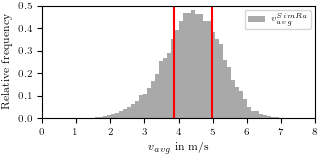

In [26]:
# Avg speed of all rides in m/s
# fig = plt.figure(figsize=[20, 10])

ax = plt.axes()
# ax.grid()
# ax.xaxis.set_major_locator(ticker.LinearLocator(numticks=30))
# ax.set_ylabel('Rides')
# ax.set_xlabel('Avg Speed (m/s)')
# plot_graph(pdf_avg_0['avg_speed'], "Slow rides (first 25%)", False, 400, False, 1.3, 7.9, 0, 500)
# plot_graph(pdf_avg_1['avg_speed'], "Medium rides (middle 50%)", False, 200, False, 1.3, 7.9, 0, 500)
# plot_graph(pdf_avg_2['avg_speed'], "Fast rides (last 25%)", False, 400, False, 1.3, 7.9, 0, 500)
# plot_graph(pdf_avg_all['avg_speed'], "All rides", True, 200, True, 1.3, 7.9, 0, 0.5)
plt.hist(pdf_avg_all['avg_speed'], bins=65, density=True, label=r'$v_{avg}^{SimRa}$', color='darkgrey')

plt.xlabel(r'$v_{avg}$ in m/s')
plt.ylabel('Relative frequency')
plt.vlines([pdf_avg_all['avg_speed'].iloc[int(0.25 * len(pdf_avg_all['avg_speed']))], pdf_avg_all['avg_speed'].iloc[int(0.75 * len(pdf_avg_all['avg_speed']))]], 0, 1, colors='r')
plt.xlim(0, 8)
plt.ylim(0, 0.5)

plt.legend()

params.update(**pdf_params)
plt.rcParams.update(params)
plt.savefig("images/velo_avg_all_rides_new.pdf", bbox_inches='tight')
print("slow cyclists avg velocity up to {}".format(pdf_avg_all['avg_speed'].iloc[int(0.25 * len(pdf_avg_all['avg_speed']))]))
print("medium cyclists avg velocity up to {}".format(pdf_avg_all['avg_speed'].iloc[int(0.75 * len(pdf_avg_all['avg_speed']))]))


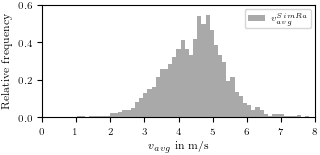

In [25]:
# Avg speed of all rides in m/s
# fig = plt.figure(figsize=[20, 10])

ax = plt.axes()
# ax.grid()
# ax.xaxis.set_major_locator(ticker.LinearLocator(numticks=30))
# ax.set_ylabel('Rides')
# ax.set_xlabel('Avg Speed (m/s)')
# plot_graph(pdf_avg_0['avg_speed'], "Slow rides (first 25%)", False, 400, False, 1.3, 7.9, 0, 500)
# plot_graph(pdf_avg_1['avg_speed'], "Medium rides (middle 50%)", False, 200, False, 1.3, 7.9, 0, 500)
# plot_graph(pdf_avg_2['avg_speed'], "Fast rides (last 25%)", False, 400, False, 1.3, 7.9, 0, 500)
# plot_graph(pdf_avg_all['avg_speed'], "All rides", True, 200, True, 1.3, 7.9, 0, 0.5)
plt.hist(pdf_avg_eb['avg_speed'], bins=65, density=True, label=r'$v_{avg}^{SimRa}$', color='darkgrey')

plt.xlabel(r'$v_{avg}$ in m/s')
plt.ylabel('Relative frequency')
#plt.vlines([pdf_avg_eb['avg_speed'].iloc[int(0.25 * len(pdf_avg_eb['avg_speed']))], pdf_avg_eb['avg_speed'].iloc[int(0.75 * len(pdf_avg_eb['avg_speed']))]], 0, 1, colors='r')
plt.xlim(0, 8)
plt.ylim(0, 0.6)

plt.legend()

params.update(**pdf_params)
plt.rcParams.update(params)
plt.savefig("images/velo_avg_eb_rides_new.pdf", bbox_inches='tight')
#print("slow cyclists avg velocity up to {}".format(pdf_avg_eb['avg_speed'].iloc[int(0.25 * len(pdf_avg_eb['avg_speed']))]))
#print("medium cyclists avg velocity up to {}".format(pdf_avg_eb['avg_speed'].iloc[int(0.75 * len(pdf_avg_eb['avg_speed']))]))


slow cyclists avg velocity up to 3.7672134711260603
medium cyclists avg velocity up to 4.97702996645205


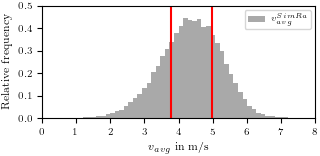

In [27]:
# Avg speed of all rides in m/s
# fig = plt.figure(figsize=[20, 10])

ax = plt.axes()
# ax.grid()
# ax.xaxis.set_major_locator(ticker.LinearLocator(numticks=30))
# ax.set_ylabel('Rides')
# ax.set_xlabel('Avg Speed (m/s)')
# plot_graph(pdf_avg_0['avg_speed'], "Slow rides (first 25%)", False, 400, False, 1.3, 7.9, 0, 500)
# plot_graph(pdf_avg_1['avg_speed'], "Medium rides (middle 50%)", False, 200, False, 1.3, 7.9, 0, 500)
# plot_graph(pdf_avg_2['avg_speed'], "Fast rides (last 25%)", False, 400, False, 1.3, 7.9, 0, 500)
# plot_graph(pdf_avg_all['avg_speed'], "All rides", True, 200, True, 1.3, 7.9, 0, 0.5)
plt.hist(pdf_avg_all_everything['avg_speed'], bins=65, density=True, label=r'$v_{avg}^{SimRa}$', color='darkgrey')

plt.xlabel(r'$v_{avg}$ in m/s')
plt.ylabel('Relative frequency')
plt.vlines([pdf_avg_all_everything['avg_speed'].iloc[int(0.25 * len(pdf_avg_all_everything['avg_speed']))], pdf_avg_all_everything['avg_speed'].iloc[int(0.75 * len(pdf_avg_all_everything['avg_speed']))]], 0, 1, colors='r')
plt.xlim(0, 8)
plt.ylim(0, 0.5)

plt.legend()

params.update(**pdf_params)
plt.rcParams.update(params)
plt.savefig("images/velo_avg_all_everything_rides_new.pdf", bbox_inches='tight')
print("slow cyclists avg velocity up to {}".format(pdf_avg_all_everything['avg_speed'].iloc[int(0.25 * len(pdf_avg_all_everything['avg_speed']))]))
print("medium cyclists avg velocity up to {}".format(pdf_avg_all_everything['avg_speed'].iloc[int(0.75 * len(pdf_avg_all_everything['avg_speed']))]))


slow cyclists avg velocity up to 3.767142115126847
medium cyclists avg velocity up to 4.97702996645205


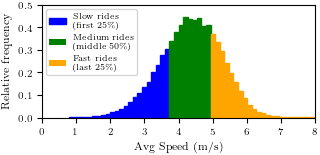

In [24]:
# Avg speed of all rides in m/s
# fig = plt.figure(figsize=[20, 10])

ax = plt.axes()
# ax.grid()
# ax.xaxis.set_major_locator(ticker.LinearLocator(numticks=30))
# ax.set_ylabel('Rides')
# ax.set_xlabel('Avg Speed (m/s)')
# plot_graph(pdf_avg_0['avg_speed'], "Slow rides (first 25%)", False, 400, False, 1.3, 7.9, 0, 500)
# plot_graph(pdf_avg_1['avg_speed'], "Medium rides (middle 50%)", False, 200, False, 1.3, 7.9, 0, 500)
# plot_graph(pdf_avg_2['avg_speed'], "Fast rides (last 25%)", False, 400, False, 1.3, 7.9, 0, 500)
# plot_graph(pdf_avg_all['avg_speed'], "All rides", True, 200, True, 1.3, 7.9, 0, 0.5)
plt.hist(pdf_avg_all['avg_speed'], bins=65, density=True, label='Slow rides\n(first 25\%)', color = 'blue')
plt.hist([], bins=1, density=True, label='Medium rides\n(middle 50\%)', color='green', alpha=1)
plt.hist([], bins=1, density=True, label='Fast rides\n(last 25\%)', color='orange', alpha=1)

for bar in ax.containers[0]:
    # get x midpoint of bar
    x = bar.get_x() + 0.5 * bar.get_width()

    # set bar color based on x
    if x <= pdf_avg_all['avg_speed'].iloc[int(0.25 * len(pdf_avg_all['avg_speed']))]:
        bar.set_color('blue')
    elif x >= pdf_avg_all['avg_speed'].iloc[int(0.75 * len(pdf_avg_all['avg_speed']))]:
        bar.set_color('orange')
    else:
        bar.set_color('green')


plt.xlabel('Avg Speed (m/s)')
plt.ylabel('Relative frequency')
# plt.vlines([pdf_avg_all['avg_speed'].iloc[int(0.25 * len(pdf_avg_all['avg_speed']))], pdf_avg_all['avg_speed'].iloc[int(0.75 * len(pdf_avg_all['avg_speed']))]], 0, 1, colors='r', linewidth=2)
plt.xlim(0, 8)
plt.ylim(0, 0.5)

plt.legend()

params.update(**pdf_params)
plt.rcParams.update(params)
plt.savefig("images/velo_avg_all_rides_new_bla.pdf", bbox_inches='tight')
print("slow cyclists avg velocity up to {}".format(pdf_avg_all['avg_speed'].iloc[int(0.25 * len(pdf_avg_all['avg_speed']))]))
print("medium cyclists avg velocity up to {}".format(pdf_avg_all['avg_speed'].iloc[int(0.75 * len(pdf_avg_all['avg_speed']))]))


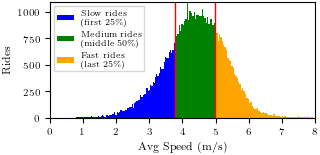

In [25]:
# Avg speed of all groups in m/s
# fig = plt.figure(figsize=[20, 10])

ax = plt.axes()
# ax.grid()
# ax.xaxis.set_major_locator(ticker.LinearLocator(numticks=30))

# plot_graph(pdf_avg_0['avg_speed'], "Slow rides (first 25\%)", False, 80, False, 1.3, 7.9, 0, 1100)
# plot_graph(pdf_avg_1['avg_speed'], "Medium rides (middle 50\%)", False, 30, False, 1.3, 7.9, 0, 1100)
# plot_graph(pdf_avg_2['avg_speed'], "Fast rides (last 25\%)", False, 110, False, 1.3, 7.9, 0, 1100)
plt.hist(pdf_avg_0['avg_speed'], bins=80, density=False, label='Slow rides\n(first 25\%)', color='blue')
plt.hist(pdf_avg_1['avg_speed'], bins=30, density=False, label='Medium rides\n(middle 50\%)', color='green')
plt.hist(pdf_avg_2['avg_speed'], bins=110, density=False, label='Fast rides\n(last 25\%)', color='orange')
ax.set_ylabel('Rides')
ax.set_xlabel('Avg Speed (m/s)')
plt.vlines([pdf_avg_all['avg_speed'].iloc[int(0.25 * len(pdf_avg_all['avg_speed']))], pdf_avg_all['avg_speed'].iloc[int(0.75 * len(pdf_avg_all['avg_speed']))]], 0, 1100, linewidth=1, colors='r')
plt.xlim(0, 8)
plt.ylim(0, 1100)
plt.legend()

params.update(**pdf_params)
plt.rcParams.update(params)
plt.savefig("images/velo_avg_groups_new.pdf", bbox_inches='tight')

13892
27717
13851


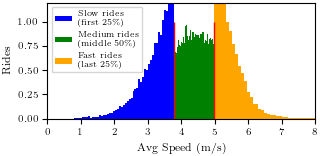

In [26]:
# Avg speed of all groups in m/s
# fig = plt.figure(figsize=[20, 10])

ax = plt.axes()
# ax.grid()
# ax.xaxis.set_major_locator(ticker.LinearLocator(numticks=30))

# plot_graph(pdf_avg_0['avg_speed'], "Slow rides (first 25\%)", False, 80, False, 1.3, 7.9, 0, 1100)
# plot_graph(pdf_avg_1['avg_speed'], "Medium rides (middle 50\%)", False, 30, False, 1.3, 7.9, 0, 1100)
# plot_graph(pdf_avg_2['avg_speed'], "Fast rides (last 25\%)", False, 110, False, 1.3, 7.9, 0, 1100)
print(len(pdf_avg_0['avg_speed']))
print(len(pdf_avg_1['avg_speed']))
print(len(pdf_avg_2['avg_speed']))
plt.hist(pdf_avg_0['avg_speed'], bins=51, density=True, label='Slow rides\n(first 25\%)', color='blue')
plt.hist(pdf_avg_1['avg_speed'], bins=51, density=True, label='Medium rides\n(middle 50\%)', color='green')
plt.hist(pdf_avg_2['avg_speed'], bins=51, density=True, label='Fast rides\n(last 25\%)', color='orange')
ax.set_ylabel('Rides')
ax.set_xlabel('Avg Speed (m/s)')
plt.vlines([pdf_avg_all['avg_speed'].iloc[int(0.25 * len(pdf_avg_all['avg_speed']))], pdf_avg_all['avg_speed'].iloc[int(0.75 * len(pdf_avg_all['avg_speed']))]], 0, 1, linewidth=1, colors='r')
plt.xlim(0, 8)
plt.ylim(0, 1.2)
plt.legend()

params.update(**pdf_params)
plt.rcParams.update(params)
plt.savefig("images/velo_avg_groups_new_density.pdf", bbox_inches='tight')

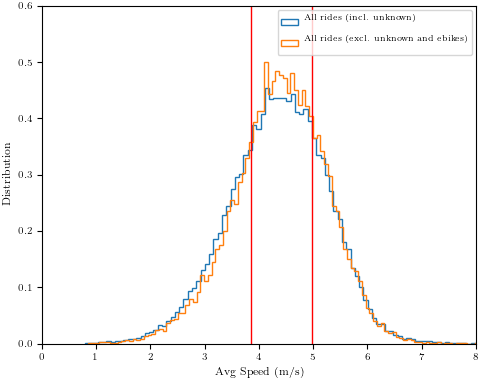

In [24]:
# Avg speed of all groups in m/s
fig = plt.figure(figsize=[5, 4])

ax = plt.axes()
# ax.grid()
# ax.xaxis.set_major_locator(ticker.LinearLocator(numticks=30))

# plot_graph(pdf_avg_0['avg_speed'], "Slow rides (first 25\%)", False, 80, False, 1.3, 7.9, 0, 1100)
# plot_graph(pdf_avg_1['avg_speed'], "Medium rides (middle 50\%)", False, 30, False, 1.3, 7.9, 0, 1100)
# plot_graph(pdf_avg_2['avg_speed'], "Fast rides (last 25\%)", False, 110, False, 1.3, 7.9, 0, 1100)
# plt.hist(pdf_avg_0_everything['avg_speed'], bins=80, density=False, label='E Slow rides\n(first 25\%)', histtype='step')
# plt.hist(pdf_avg_1_everything['avg_speed'], bins=30, density=False, label='E Medium rides\n(middle 50\%)', histtype='step')
# plt.hist(pdf_avg_2_everything['avg_speed'], bins=110, density=False, label='E Fast rides\n(last 25\%)', histtype='step')
plt.hist(pdf_avg_all_everything['avg_speed'], bins=110, density=True, label='All rides (incl. unknown)\n', histtype='step')
# plt.hist(pdf_avg_0['avg_speed'], bins=80, density=False, label='Slow rides\n(first 25\%)', histtype='step')
# plt.hist(pdf_avg_1['avg_speed'], bins=30, density=False, label='Medium rides\n(middle 50\%)', histtype='step')
# plt.hist(pdf_avg_2['avg_speed'], bins=110, density=False, label='Fast rides\n(last 25\%)', histtype='step')
plt.hist(pdf_avg_all['avg_speed'], bins=110, density=True, label='All rides (excl. unknown and ebikes)\n', histtype='step')
ax.set_ylabel('Distribution')
ax.set_xlabel('Avg Speed (m/s)')
plt.vlines([
    pdf_avg_all['avg_speed'].iloc[int(0.25 * len(pdf_avg_all['avg_speed']))], 
    pdf_avg_all['avg_speed'].iloc[int(0.75 * len(pdf_avg_all['avg_speed']))]
    ], 0, 1100, linewidth=1, colors='r')
plt.xlim(0, 8)
plt.ylim(0, 0.6)
plt.legend()

params.update(**pdf_params)
plt.rcParams.update(params)
plt.savefig("images/velo_avg_everything_groups_new.pdf", bbox_inches='tight')

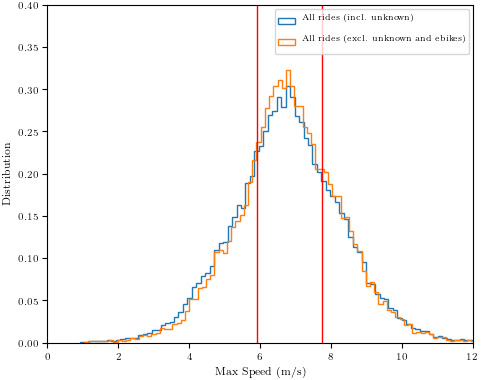

In [25]:
# Avg speed of all groups in m/s
fig = plt.figure(figsize=[5, 4])

ax = plt.axes()
# ax.grid()
# ax.xaxis.set_major_locator(ticker.LinearLocator(numticks=30))

# plot_graph(pdf_avg_0['avg_speed'], "Slow rides (first 25\%)", False, 80, False, 1.3, 7.9, 0, 1100)
# plot_graph(pdf_avg_1['avg_speed'], "Medium rides (middle 50\%)", False, 30, False, 1.3, 7.9, 0, 1100)
# plot_graph(pdf_avg_2['avg_speed'], "Fast rides (last 25\%)", False, 110, False, 1.3, 7.9, 0, 1100)
# plt.hist(pdf_avg_0_everything['avg_speed'], bins=80, density=False, label='E Slow rides\n(first 25\%)', histtype='step')
# plt.hist(pdf_avg_1_everything['avg_speed'], bins=30, density=False, label='E Medium rides\n(middle 50\%)', histtype='step')
# plt.hist(pdf_avg_2_everything['avg_speed'], bins=110, density=False, label='E Fast rides\n(last 25\%)', histtype='step')
plt.hist(pdf_max_all_everything['max_speed'], bins=110, density=True, label='All rides (incl. unknown)\n', histtype='step')
# plt.hist(pdf_avg_0['avg_speed'], bins=80, density=False, label='Slow rides\n(first 25\%)', histtype='step')
# plt.hist(pdf_avg_1['avg_speed'], bins=30, density=False, label='Medium rides\n(middle 50\%)', histtype='step')
# plt.hist(pdf_avg_2['avg_speed'], bins=110, density=False, label='Fast rides\n(last 25\%)', histtype='step')
plt.hist(pdf_max_all['max_speed'], bins=110, density=True, label='All rides (excl. unknown and ebikes)\n', histtype='step')
ax.set_ylabel('Distribution')
ax.set_xlabel('Max Speed (m/s)')
plt.vlines([
    pdf_max_all['max_speed'].iloc[int(0.25 * len(pdf_max_all['max_speed']))], 
    pdf_max_all['max_speed'].iloc[int(0.75 * len(pdf_max_all['max_speed']))]
    ], 0, 1100, linewidth=1, colors='r')
plt.xlim(0, 12)
plt.ylim(0, 0.4)
plt.legend()

params.update(**pdf_params)
plt.rcParams.update(params)
plt.savefig("images/velo_max_everything_groups_new.pdf", bbox_inches='tight')

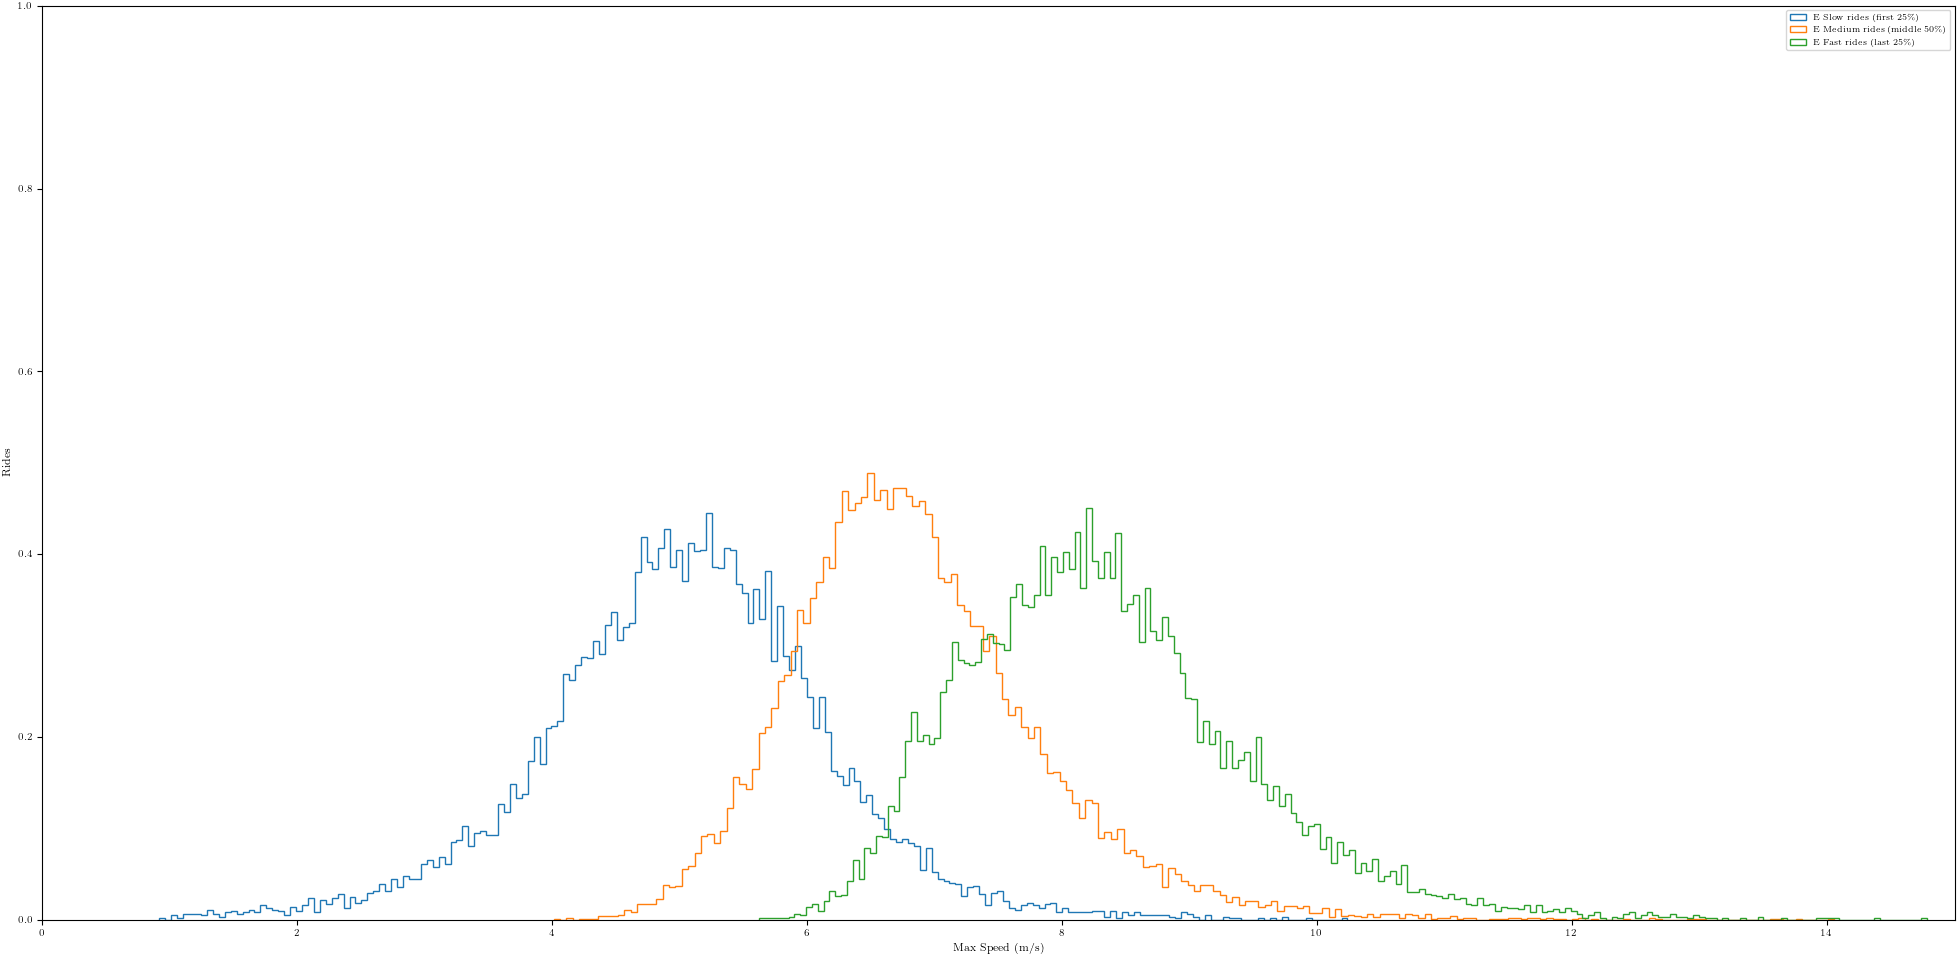

<Figure size 339.5x175 with 0 Axes>

In [35]:
# Max speed of all groups in m/s
fig = plt.figure(figsize=[20, 10])

ax = plt.axes()
# ax.grid()
# ax.xaxis.set_major_locator(ticker.LinearLocator(numticks=30))
ax.set_ylabel('Rides')
ax.set_xlabel('Max Speed (m/s)')

#plot_graph(pdf_avg_0['avg_speed'], "Group 0", False)
plot_graph(pdf_max_0_everything['max_speed'], "E Slow rides (first 25\%)", False, 200, True, 0, 15, 0, 1)

#plot_graph(pdf_avg_1['avg_speed'], "Group 1", False)
plot_graph(pdf_max_1_everything['max_speed'], "E Medium rides (middle 50\%)", False, 200, True, 0, 15, 0, 1)

#plot_graph(pdf_avg_2['avg_speed'], "Group 2", False)
plot_graph(pdf_max_2_everything['max_speed'], "E Fast rides (last 25\%)", False, 200, True, 0, 15, 0, 1)

#plot_graph(pdf_avg_0['avg_speed'], "Group 0", False)
# plot_graph(pdf_max_0['max_speed'], "Slow rides (first 25\%)", False, 200, True, 0, 15, 0, 1)

# #plot_graph(pdf_avg_1['avg_speed'], "Group 1", False)
# plot_graph(pdf_max_1['max_speed'], "Medium rides (middle 50\%)", False, 200, True, 0, 15, 0, 1)

# #plot_graph(pdf_avg_2['avg_speed'], "Group 2", False)
# plot_graph(pdf_max_2['max_speed'], "Fast rides (last 25\%)", False, 200, True, 0, 15, 0, 1)

#plot_graph(pdf_avg_2['avg_speed'], "Group 2", False)
#plot_graph(pdf_max_eb['max_speed'], "Ebikes", False, 200, True, 0, 15, 0, 1)

plt.legend()
plt.show()
plt.savefig("images/velo_max_groups_new.png", dpi=300, bbox_inches='tight')

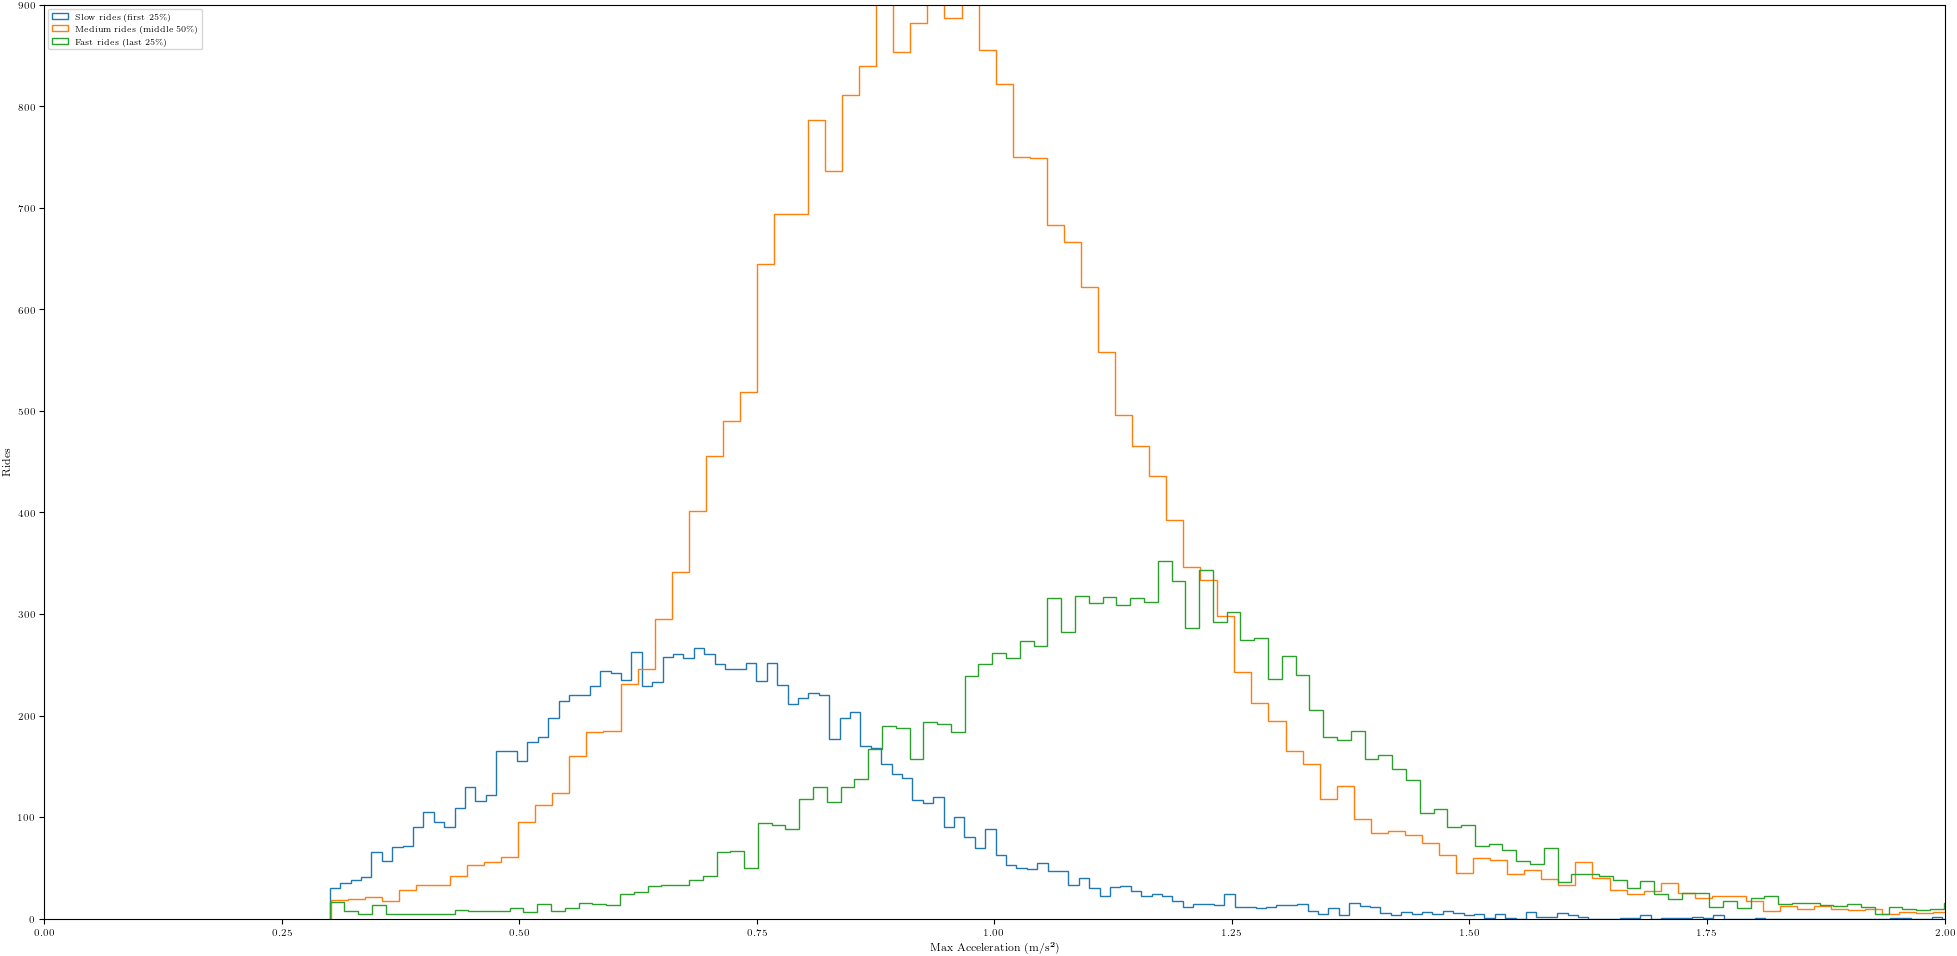

<Figure size 339.5x175 with 0 Axes>

In [28]:
# Max acceleration of all groups in m/s
fig = plt.figure(figsize=[20, 10])

ax = plt.axes()
# ax.grid()
# ax.xaxis.set_major_locator(ticker.LinearLocator(numticks=30))
ax.set_ylabel('Rides')
ax.set_xlabel('Max Acceleration (m/s²)')
plt.xlim(0, 2)

#plot_graph(pdf_avg_0['avg_speed'], "Group 0", False)
plot_graph(pdf_acc_0['max_accel'], "Slow rides (first 25\%)", False, 200, False, 0, 2, 0, 900)

#plot_graph(pdf_avg_1['avg_speed'], "Group 1", False)
plot_graph(pdf_acc_1['max_accel'], "Medium rides (middle 50\%)", False, 200, False, 0, 2, 0, 900)

#plot_graph(pdf_avg_2['avg_speed'], "Group 2", False)
plot_graph(pdf_acc_2['max_accel'], "Fast rides (last 25\%)", False, 200, False, 0, 2, 0, 900)

plt.legend()
plt.show()
plt.savefig("images/acc_max_groups_new.png", dpi=300, bbox_inches='tight')

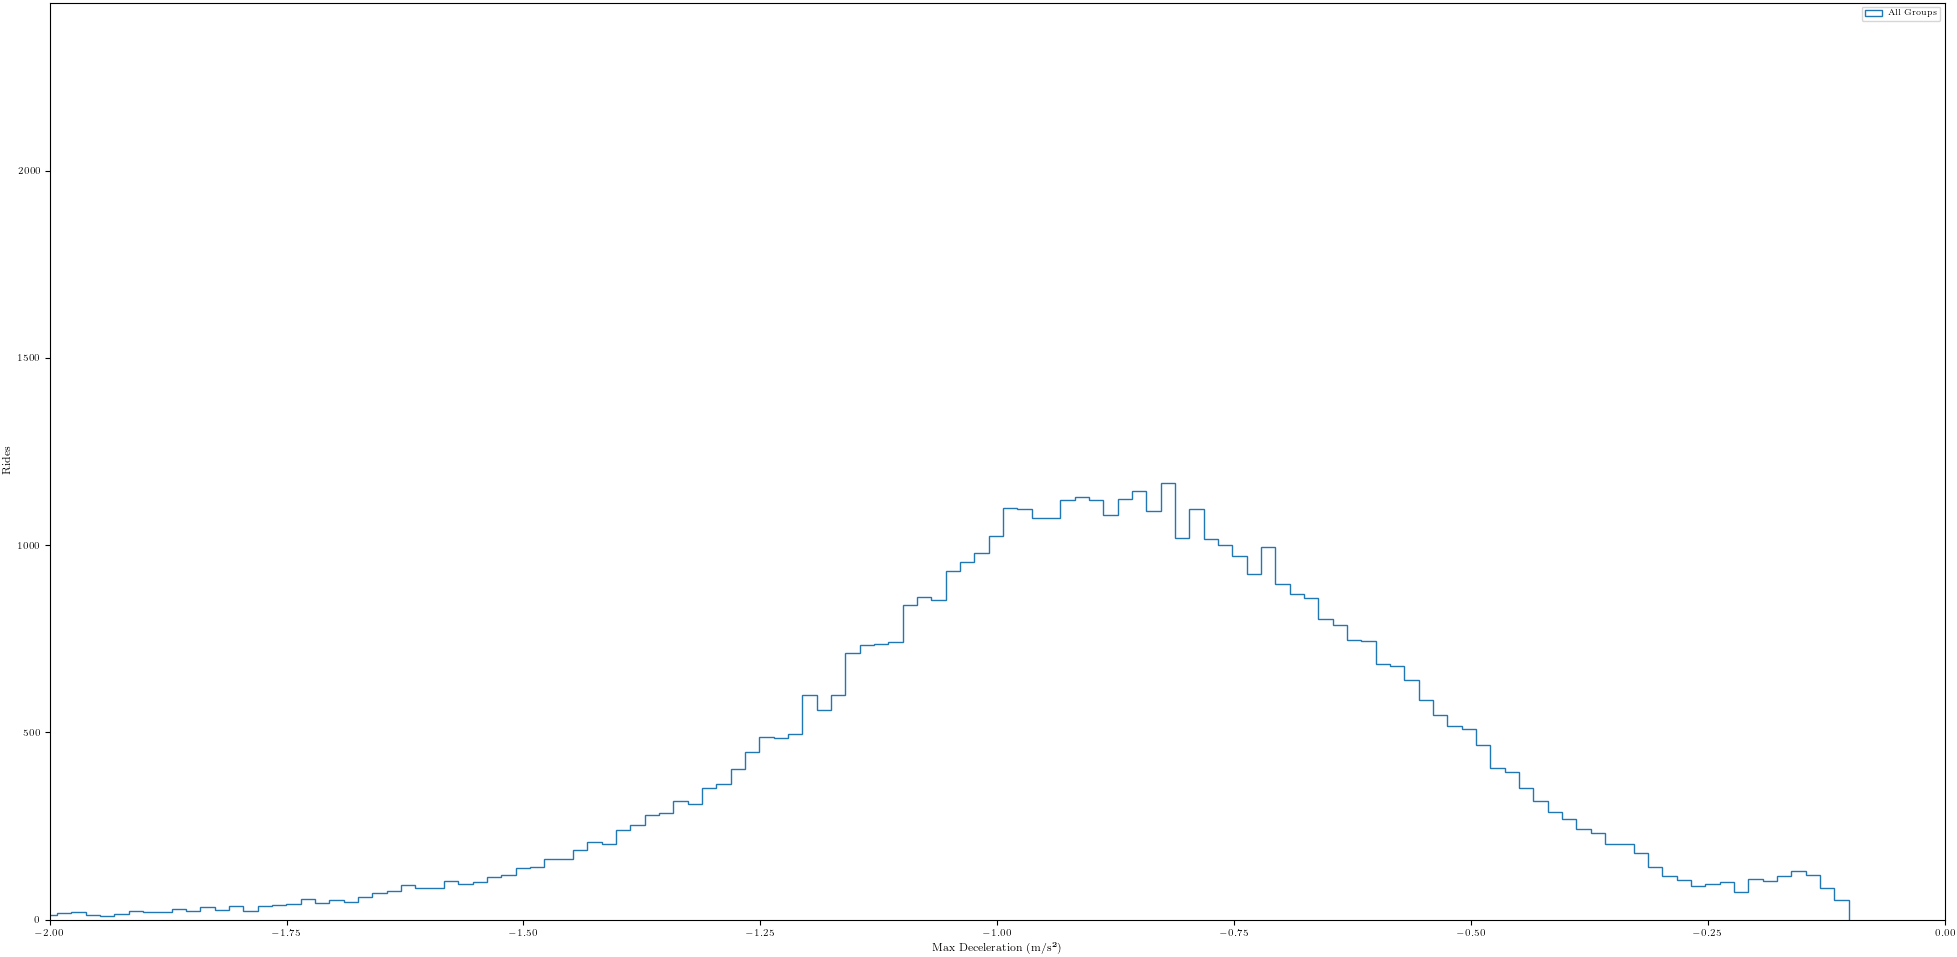

In [29]:
# Max deceleration of all groups combined in m/s
fig = plt.figure(figsize=[20, 10])

ax = plt.axes()
# ax.grid()
# ax.xaxis.set_major_locator(ticker.LinearLocator(numticks=30))
ax.set_ylabel('Rides')
ax.set_xlabel('Max Deceleration (m/s²)')
# plt.xlim(-1.2, 0)

#plot_graph(pdf_avg_0['avg_speed'], "Group 0", False)
plot_graph(pdf_dec_all['max_decel'], "All Groups", False, 200, False, -2, 0, 0, 2450)

#plot_graph(pdf_avg_1['avg_speed'], "Group 1", False)
#plot_graph(pdf_acc_1['max_accel'], "Group 1", False)

#plot_graph(pdf_avg_2['avg_speed'], "Group 2", False)
#plot_graph(pdf_acc_2['max_accel'], "Group 2", False)

plt.legend()
plt.show()

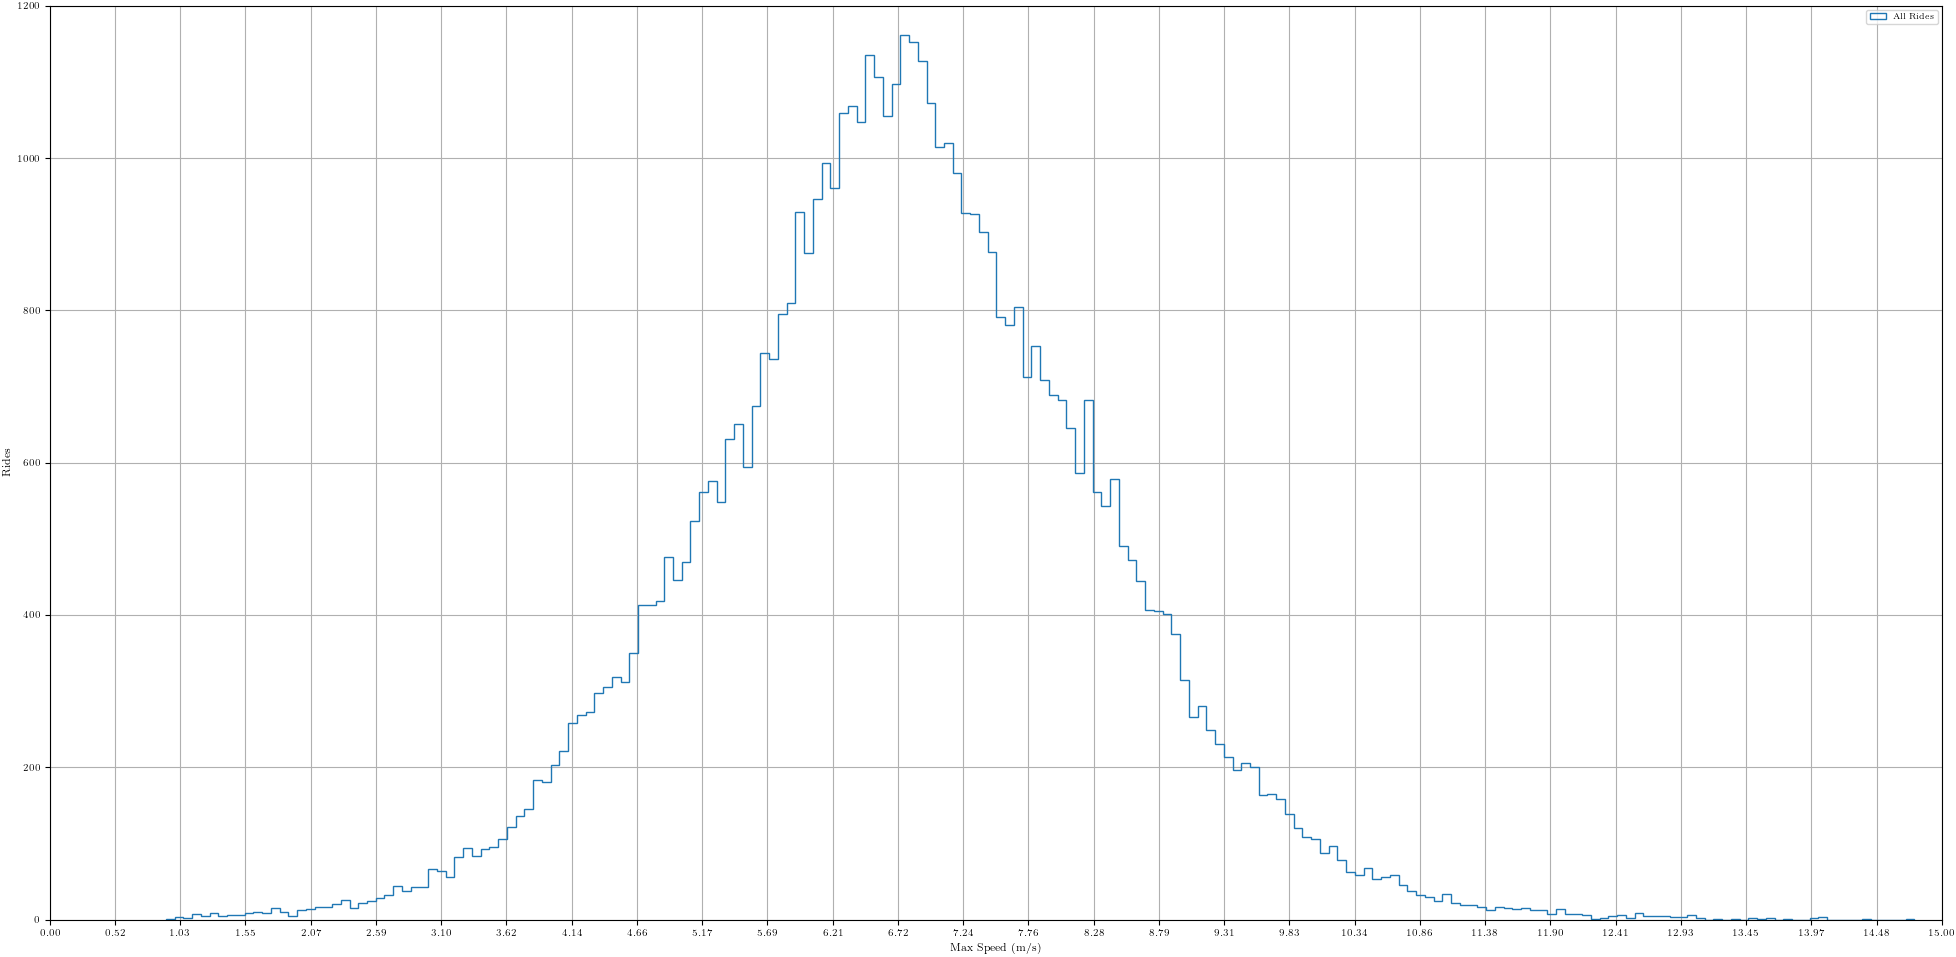

In [30]:
# Max speed of all rides in m/s
fig = plt.figure(figsize=[20, 10])

ax = plt.axes()
ax.grid()
ax.xaxis.set_major_locator(ticker.LinearLocator(numticks=30))
ax.set_ylabel('Rides')
ax.set_xlabel('Max Speed (m/s)')

#plot_graph(pdf_avg_0['avg_speed'], "Group 0", False)
plot_graph(pdf_all['max_speed'], "All Rides", False, 200, False, 0, 15, 0, 1200)

plt.legend()
plt.show()

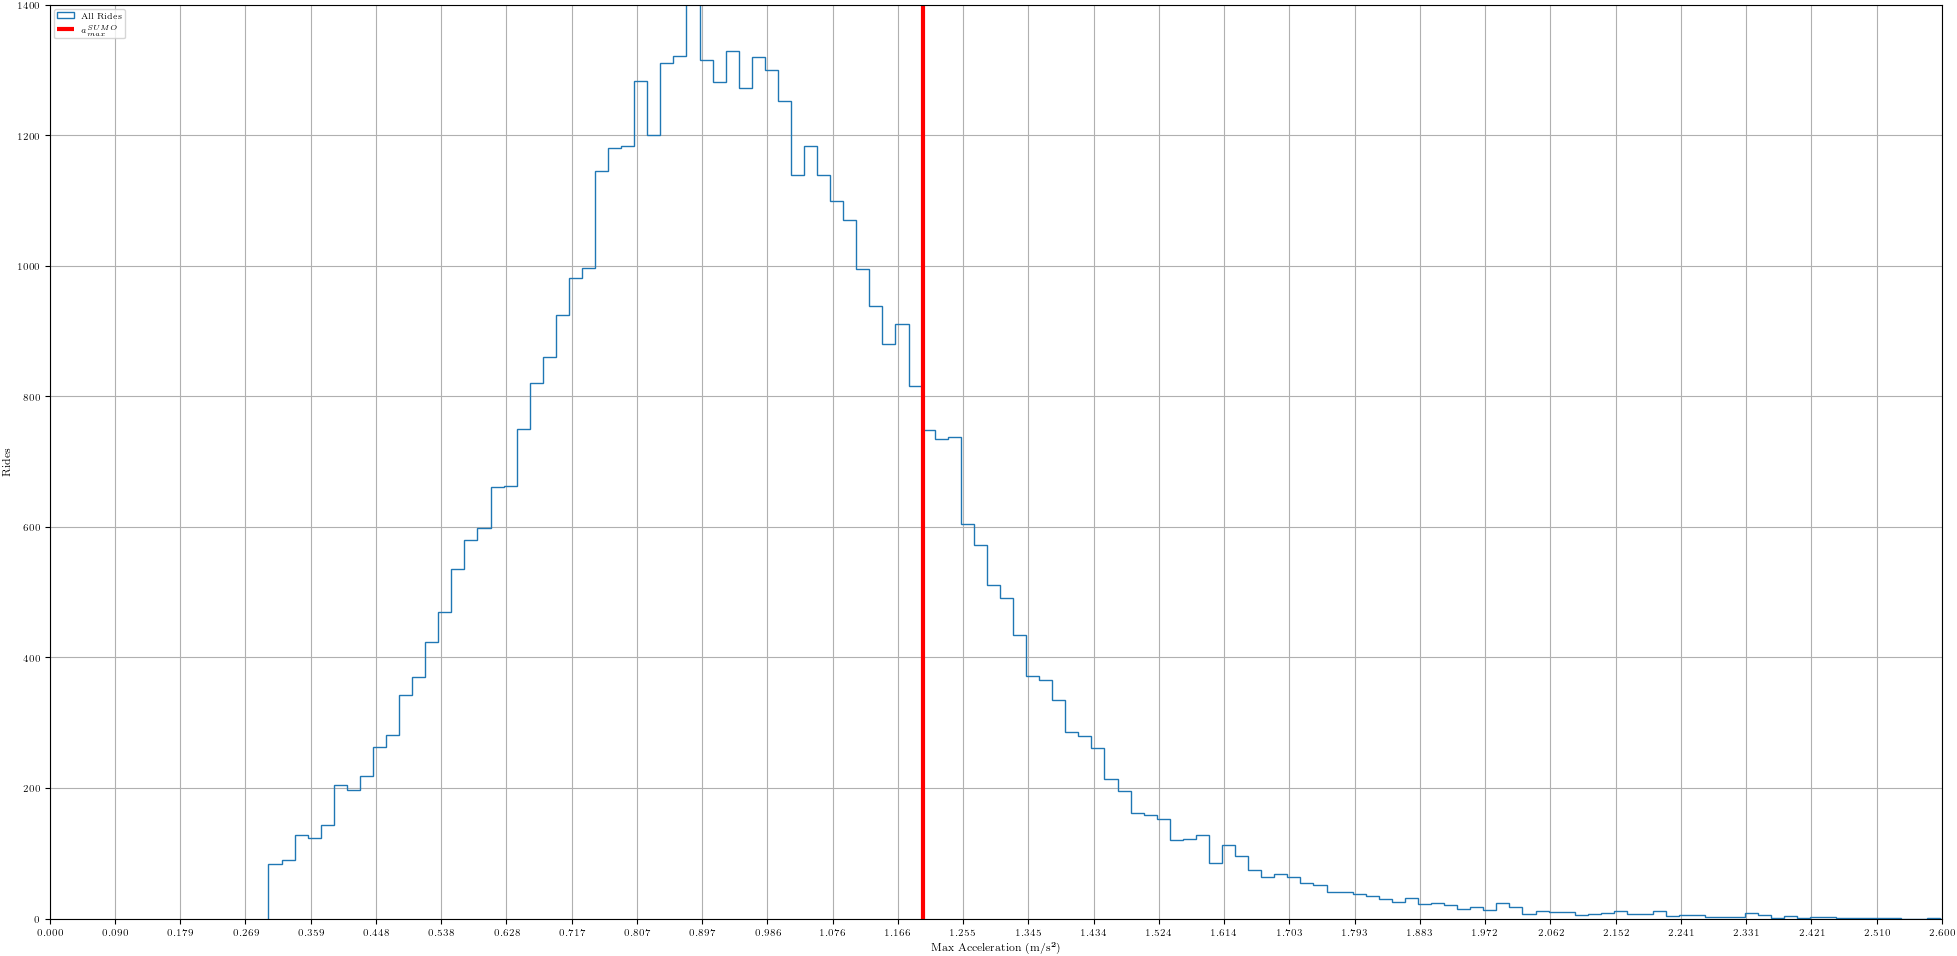

In [31]:
# Max acceleration of all rides in m/s
fig = plt.figure(figsize=[20, 10])

ax = plt.axes()
ax.grid()
ax.xaxis.set_major_locator(ticker.LinearLocator(numticks=30))
ax.set_ylabel('Rides')
ax.set_xlabel('Max Acceleration (m/s²)')

#plot_graph(pdf_avg_0['avg_speed'], "Group 0", False)
plot_graph(pdf_acc_all['max_accel'], "All Rides", False, 200, False, 0, 2.6, 0, 1400)
plt.vlines(1.2, 0, 10000, colors='r', linewidth=3, label=r'$a_{max}^{SUMO}$')

plt.legend()
plt.show()

In [32]:
def limit_cpu():
    '''This is called at every process call and deprioritizes the process according to the OS.
    This way the machine stays usable during import'''
    p = psutil.Process(os.getpid())
    if platform == "darwin" or "linux": #OS X or Linux
        p.nice(19)                                  # lowest priority class
    elif platform == "win32": #Windows
        p.nice(psutil.BELOW_NORMAL_PRIORITY_CLASS)  # below normal priority

In [33]:
# Find the best distribution for group 0 v_max

list_of_dists_for_v_max = ['beta', 'betaprime', 'bradford', 'burr', 'burr12', 'cauchy', 'chi', 'chi2', 'cosine', 'dgamma', 'dweibull', 'erlang', 'expon', 'exponnorm', 'exponweib', 'exponpow', 'f', 'fatiguelife', 'fisk', 'foldcauchy', 'foldnorm', 'genlogistic', 'genpareto', 'gennorm', 'genexpon', 'genextreme', 'gausshyper', 'gamma', 'gengamma', 'genhalflogistic', 'gilbrat', 'gompertz', 'gumbel_r', 'gumbel_l', 'halfcauchy', 'halflogistic', 'halfnorm', 'halfgennorm', 'hypsecant', 'invgamma', 'invgauss', 'invweibull', 'johnsonsb', 'johnsonsu', 'kstwobign', 'laplace', 'levy', 'levy_l', 'logistic', 'loggamma', 'loglaplace', 'lognorm', 'lomax', 'maxwell', 'mielke', 'nakagami', 'ncx2', 'ncf', 'nct', 'norm', 'pareto', 'pearson3', 'powerlaw', 'powerlognorm', 'powernorm', 'rdist', 'reciprocal', 'rayleigh', 'rice', 'recipinvgauss', 'semicircular', 't', 'triang', 'truncexpon', 'truncnorm', 'tukeylambda', 'uniform', 'vonmises', 'vonmises_line', 'wald', 'weibull_min', 'weibull_max']

results=[]
def parallel_p(i):
    try:
        dist = getattr(scipy.stats, i)
        param = dist.fit(pdf_max_0['max_speed'])
        a0 = scipy.stats.kstest(pdf_max_0['max_speed'], i, args=param)
        # print("{}: statistic={}, pvalue={}".format(i, a[0], a[1]))
        # print("done " + str(i), end=";", flush=True)
        return (i, a0[0], a0[1], param)
    except ValueError as e:
        print("      error type {} for {}".format(e,i))
        return None

p = Pool(None, limit_cpu)
results = [val for val in p.map(parallel_p, list_of_dists_for_v_max) if val != None]

results.sort(key=lambda x:float(x[2]), reverse=True)
g0v = results[0]
for j in results:
    print("{}: statistic={}, pvalue={}, param={}".format(j[0], j[1], j[2], j[3]))

genlogistic: statistic=0.004933591099186452, pvalue=0.88608210034759, param=(0.8956841278722569, 5.147144211532806, 0.5779873919715002)
johnsonsu: statistic=0.0051841166821999796, pvalue=0.847409698869719, param=(0.1483079627749306, 2.048900584659202, 5.199727068411495, 1.9745746376072484)
mielke: statistic=0.00597075076921455, pvalue=0.7026512538122155, param=(10.990884628288583, 18.52422302984208, -3.9813373168084967, 9.443480236406312)
burr12: statistic=0.0060248198180717916, pvalue=0.6919828634155047, param=(51.54836636265382, 1.2634494431778511, -28.40352331265797, 33.66420183359523)
fisk: statistic=0.007952602791709062, pvalue=0.3415076783832609, param=(218698060.2442475, -131626319.78691003, 131626324.83621928)
logistic: statistic=0.007967223420051295, pvalue=0.3393361123738394, param=(5.049304142964365, 0.6019065861271071)
t: statistic=0.00805676490135554, pvalue=0.3262382856284911, param=(7.6933167048269375, 5.04821677817899, 0.9419476814746723)
tukeylambda: statistic=0.008127

In [34]:
# Find the best distribution for group 1 v_max

results=[]
def parallel_p(i):
    try:
        dist = getattr(scipy.stats, i)
        param = dist.fit(pdf_max_1['max_speed'])
        a0 = scipy.stats.kstest(pdf_max_1['max_speed'], i, args=param)
        # print("{}: statistic={}, pvalue={}".format(i, a[0], a[1]))
        # print("done " + str(i), end=";", flush=True)
        return (i, a0[0], a0[1], param)
    except ValueError as e:
        print("      error type {} for {}".format(e,i))
        return None

p = Pool(None, limit_cpu)
results = [val for val in p.map(parallel_p, list_of_dists_for_v_max) if val != None]

results.sort(key=lambda x:float(x[2]), reverse=True)
g1v = results[0]
# for j in results:
for j in range (0,2):
    print("{}: statistic={}, pvalue={}, param={}".format(results[j][0], results[j][1], results[j][2], results[j][3]))

exponnorm: statistic=0.0036389445841834567, pvalue=0.8551196470289849, param=(1.1434625995440038, 6.1204210973464654, 0.6386087270558589)
genlogistic: statistic=0.0047894884441402885, pvalue=0.5467916198561671, param=(3.286328803582911, 5.751059693343479, 0.6844020705864349)


In [35]:
# Find the best distribution for group 2 v_max

results=[]
def parallel_p(i):
    try:
        dist = getattr(scipy.stats, i)
        param = dist.fit(pdf_max_2['max_speed'])
        a0 = scipy.stats.kstest(pdf_max_2['max_speed'], i, args=param)
        # print("{}: statistic={}, pvalue={}".format(i, a[0], a[1]))
        return (i, a0[0], a0[1], param)
    except ValueError as e:
        print("      error type {} for {}".format(e,i))
        return None

p = Pool(None, limit_cpu)
results = [val for val in p.map(parallel_p, list_of_dists_for_v_max) if val != None]

results.sort(key=lambda x:float(x[2]), reverse=True)
g2v = results[0]
for j in range (0,2):
    print("{}: statistic={}, pvalue={}, param={}".format(results[j][0], results[j][1], results[j][2], results[j][3]))
# for j in results:
#     print("{}: statistic={}, pvalue={}, param={}".format(j[0], j[1], j[2], j[3]))

nct: statistic=0.011584247654714552, pvalue=0.048214026105488084, param=(33.98189195983613, 35.20777514015745, -0.10106811778306185, 0.23419571755831436)
invgamma: statistic=0.012106567972684168, pvalue=0.03420955169829609, param=(29.727022272549654, 2.55371613558727, 166.01507014777076)


In [36]:
# Find the best distribution for group 0 a_max

list_of_dists_for_a_max = ['alpha', 'anglit', 'arcsine', 'beta', 'betaprime', 'bradford', 'burr', 'burr12', 'cauchy', 'chi', 'chi2', 'cosine', 'dgamma', 'dweibull', 'erlang', 'expon', 'exponnorm', 'exponweib', 'exponpow', 'f', 'fatiguelife', 'fisk', 'foldcauchy', 'foldnorm', 'genlogistic', 'genpareto', 'gennorm', 'genexpon', 'genextreme', 'gausshyper', 'gamma', 'gengamma', 'genhalflogistic', 'gilbrat', 'gompertz', 'gumbel_r', 'gumbel_l', 'halfcauchy', 'halflogistic', 'halfnorm', 'halfgennorm', 'hypsecant', 'invgamma', 'invgauss', 'invweibull', 'johnsonsb', 'johnsonsu', 'kstwobign', 'laplace', 'levy', 'levy_l', 'logistic', 'loggamma', 'loglaplace', 'lognorm', 'lomax', 'maxwell', 'mielke', 'nakagami', 'ncx2', 'ncf', 'nct', 'norm', 'pareto', 'pearson3', 'powerlaw', 'powerlognorm', 'powernorm', 'rdist', 'reciprocal', 'rayleigh', 'rice', 'recipinvgauss', 'semicircular', 't', 'triang', 'truncexpon', 'truncnorm', 'tukeylambda', 'uniform', 'vonmises', 'vonmises_line', 'wald', 'weibull_min', 'weibull_max']
results=[]
def parallel_p(i):
    try:
        dist = getattr(scipy.stats, i)
        param = dist.fit(pdf_acc_0['max_accel'])
        a0 = scipy.stats.kstest(pdf_acc_0['max_accel'], i, args=param)
        # print("{}: statistic={}, pvalue={}".format(i, a[0], a[1]))
        return (i, a0[0], a0[1], param)
    except ValueError as e:
        print("      error type {} for {}".format(e,i))
        return None

p = Pool(None, limit_cpu)
results = [val for val in p.map(parallel_p, list_of_dists_for_a_max) if val != None]

results.sort(key=lambda x:float(x[2]), reverse=True)
g0a = results[0]
for j in range (0,2):
    print("{}: statistic={}, pvalue={}, param={}".format(results[j][0], results[j][1], results[j][2], results[j][3]))
# for j in results:
#     print("{}: statistic={}, pvalue={}, param={}".format(j[0], j[1], j[2], j[3]))

mielke: statistic=0.0068631688103617805, pvalue=0.6416680903836225, param=(1.9210428947349762, 5.605647103169892, 0.2897535427045416, 0.5748759609228518)
burr: statistic=0.00686384070950094, pvalue=0.6415459502795742, param=(5.605695124534978, 0.34268996384244077, 0.2897551551846281, 0.5748782697099941)


In [37]:
# Find the best distribution for group 1 a_max

results=[]
def parallel_p(i):
    try:
        dist = getattr(scipy.stats, i)
        param = dist.fit(pdf_acc_1['max_accel'])
        a0 = scipy.stats.kstest(pdf_acc_1['max_accel'], i, args=param)
        # print("{}: statistic={}, pvalue={}".format(i, a[0], a[1]))
        return (i, a0[0], a0[1], param)
    except ValueError as e:
        print("      error type {} for {}".format(e,i))
        return None

p = Pool(None, limit_cpu)
results = [val for val in p.map(parallel_p, list_of_dists_for_a_max) if val != None]

results.sort(key=lambda x:float(x[2]), reverse=True)
g1a = results[0]
for j in range (0,2):
    print("{}: statistic={}, pvalue={}, param={}".format(results[j][0], results[j][1], results[j][2], results[j][3]))
# for j in results:
#     print("{}: statistic={}, pvalue={}, param={}".format(j[0], j[1], j[2], j[3]))

mielke: statistic=0.003970434354940933, pvalue=0.8099090124592934, param=(5.667817984928671, 7.873631047435931, 0.04705093835829806, 0.9538215937344795)
burr: statistic=0.004313483230866111, pvalue=0.7222822481633075, param=(8.289518767256396, 0.7730600469765272, -0.026358022134898886, 1.0149305508233257)


In [38]:
# Find the best distribution for group 2 a_max
results=[]
def parallel_p(i):
    try:
        dist = getattr(scipy.stats, i)
        param = dist.fit(pdf_acc_2['max_accel'])
        a0 = scipy.stats.kstest(pdf_acc_2['max_accel'], i, args=param)
        # print("{}: statistic={}, pvalue={}".format(i, a[0], a[1]))
        return (i, a0[0], a0[1], param)
    except ValueError as e:
        print("      error type {} for {}".format(e,i))
        return None

p = Pool(None, limit_cpu)
results = [val for val in p.map(parallel_p, list_of_dists_for_a_max) if val != None]

results.sort(key=lambda x:float(x[2]), reverse=True)
g2a = results[0]
for j in range (0,2):
    print("{}: statistic={}, pvalue={}, param={}".format(results[j][0], results[j][1], results[j][2], results[j][3]))
# for j in results:
#     print("{}: statistic={}, pvalue={}, param={}".format(j[0], j[1], j[2], j[3]))

mielke: statistic=0.008413828001457735, pvalue=0.32185707257624274, param=(8.744751840181486, 11.385808107262532, -0.36012846800890075, 1.562072128936747)
burr: statistic=0.008414001813474403, pvalue=0.32183318157976726, param=(11.385789131133857, 0.768039453547582, -0.3601254647782369, 1.5620694037094467)


In [39]:
# Find the best distribution for group 0 d_max
list_of_dists_for_d_max = ['powernorm','norm','exponnorm','beta','betaprime','bradford','burr','burr12','cauchy','chi','chi2','cosine','dgamma','dweibull','erlang','expon','exponnorm','exponweib','exponpow','f','fatiguelife','fisk','foldcauchy','foldnorm','genlogistic','genpareto','gennorm','genexpon','genextreme','gausshyper','gamma','gengamma','genhalflogistic','gilbrat','gompertz','gumbel_r','gumbel_l','halfcauchy','halflogistic','halfnorm','halfgennorm','hypsecant','invgamma','invgauss','invweibull','johnsonsb','johnsonsu','kstwobign','laplace','levy','levy_l','logistic','loggamma','loglaplace','lognorm','lomax','maxwell','mielke','nakagami','ncx2','ncf','nct','norm','pareto','pearson3','powerlaw','powerlognorm','powernorm','rdist','reciprocal','rayleigh','rice','recipinvgauss','semicircular','t','triang','truncexpon','truncnorm','tukeylambda','uniform','vonmises','vonmises_line','wald','weibull_min','weibull_max']
results=[]

def parallel_p(i):
    try:
        dist = getattr(scipy.stats, i)
        param = dist.fit(pdf_dec_0_abs)
        a0 = scipy.stats.kstest(pdf_dec_0_abs, i, args=param)
        # print("{}: statistic={}, pvalue={}".format(i, a[0], a[1]))
        return (i, a0[0], a0[1], param)
    except ValueError as e:
        print("      error type {} for {}".format(e,i))
        return None

p = Pool(None, limit_cpu)
results = [val for val in p.map(parallel_p, list_of_dists_for_d_max) if val != None]

results.sort(key=lambda x:float(x[2]), reverse=True)
g0d = results[0]
for j in range (0,2):
    print("{}: statistic={}, pvalue={}, param={}".format(results[j][0], results[j][1], results[j][2], results[j][3]))
# for j in results:
#     print("{}: statistic={}, pvalue={}, param={}".format(j[0], j[1], j[2], j[3]))

burr: statistic=0.00782121510674011, pvalue=0.38408858247608557, param=(6.918532968401932, 0.42824674111202377, 0.03478435050610458, 0.7549834201875604)
mielke: statistic=0.00782288276252091, pvalue=0.3838258603648502, param=(2.962788179735599, 6.918529257766093, 0.034791271436978535, 0.7549799781027172)


In [40]:
# Find the best distribution for group 1 d_max
results=[]
def parallel_p(i):
    try:
        dist = getattr(scipy.stats, i)
        param = dist.fit(pdf_dec_1_abs)
        a0 = scipy.stats.kstest(pdf_dec_1_abs, i, args=param)
        # print("{}: statistic={}, pvalue={}".format(i, a[0], a[1]))
        return (i, a0[0], a0[1], param)
    except ValueError as e:
        print("      error type {} for {}".format(e,i))
        return None

p = Pool(None, limit_cpu)
results = [val for val in p.map(parallel_p, list_of_dists_for_d_max) if val != None]

results.sort(key=lambda x:float(x[2]), reverse=True)
g1d = results[0]
for j in range (0,2):
    print("{}: statistic={}, pvalue={}, param={}".format(results[j][0], results[j][1], results[j][2], results[j][3]))
# for j in results:
#     print("{}: statistic={}, pvalue={}, param={}".format(j[0], j[1], j[2], j[3]))

tukeylambda: statistic=0.007895942021638236, pvalue=0.06744555882484993, param=(-0.05731783658515939, 0.8961798955209023, 0.13461073880462038)
johnsonsu: statistic=0.00804943932510871, pvalue=0.05904909312542139, param=(-0.17077916956453415, 1.6872690086664512, 0.8556236999633839, 0.37803859550229374)


In [41]:
# Find the best distribution for group 2 d_max
results=[]
def parallel_p(i):
    try:
        dist = getattr(scipy.stats, i)
        param = dist.fit(pdf_dec_2_abs)
        a0 = scipy.stats.kstest(pdf_dec_2_abs, i, args=param)
        # print("{}: statistic={}, pvalue={}".format(i, a[0], a[1]))
        return (i, a0[0], a0[1], param)
    except ValueError as e:
        print("      error type {} for {}".format(e,i))
        return None

p = Pool(None, limit_cpu)
results = [val for val in p.map(parallel_p, list_of_dists_for_d_max) if val != None]

results.sort(key=lambda x:float(x[2]), reverse=True)
g2d = results[0]
for j in range (0,2):
    print("{}: statistic={}, pvalue={}, param={}".format(results[j][0], results[j][1], results[j][2], results[j][3]))
# for j in results:
#     print("{}: statistic={}, pvalue={}, param={}".format(j[0], j[1], j[2], j[3]))

t: statistic=0.00831879568182017, pvalue=0.30682696684548894, param=(4.517882805489581, 1.0990697601885935, 0.24221334336220263)
tukeylambda: statistic=0.00835533289016989, pvalue=0.30187510446642485, param=(-0.09072949590466692, 1.0990172757048124, 0.1485488604632694)


0:0.14830796277493062.0489005846592025.1997270684114951.9745746376072484
1:1.14346259954400386.12042109734646540.6386087270558589
2:33.9818919598361335.20777514015745-0.101068117783061850.23419571755831436


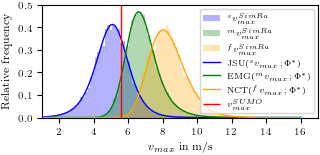

In [42]:
# plots for v_max

# plt.figure(figsize=(10,8))
# rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 16})
# rc('text', usetex=True)
plt.hist(pdf_max_0['max_speed'], bins=65, density=True, label=r'$^{s}v_{max}^{SimRa}$', alpha=0.3, color='blue')
plt.hist(pdf_max_1['max_speed'], bins=65, density=True, label=r'$^{m}v_{max}^{SimRa}$', alpha=0.3, color='green')
plt.hist(pdf_max_2['max_speed'], bins=65, density=True, label=r'$^{f}v_{max}^{SimRa}$', alpha=0.3, color='orange')

# plt.hist(pdf_max_0['max_speed'], bins=65, density=True, label=r'$^{s}v_{max}^{SimRa}$', histtype='step')
# plt.hist(pdf_max_1['max_speed'], bins=65, density=True, label=r'$^{m}v_{max}^{SimRa}$', histtype='step')
# plt.hist(pdf_max_2['max_speed'], bins=65, density=True, label=r'$^{f}v_{max}^{SimRa}$', histtype='step')

# johnsonsu: statistic=0.004896746744468827, pvalue=0.9037362281423775, param=(0.17177979659713563, 2.0052692655228785, 5.244025875304043, 1.9461729586112435)
a0, b0, c0, d0 = scipy.stats.johnsonsu.fit(pdf_max_0['max_speed']) # 0 v_max -> johnsonsu (4 params)
# exponnorm: statistic=0.003203900633740875, pvalue=0.9463245338435855, param=(1.151847776400146, 6.125155871008447, 0.6368067788368326)
a1, b1, c1 = scipy.stats.exponnorm.fit(pdf_max_1['max_speed']) # 1 v_max -> exponnorm (3 params)
# nct: statistic=0.012005331014221077, pvalue=0.04264766592061031, param=(34.71300201628809, 31.8573451917904, -0.11087431634014067, 0.25931067417519293)
a2, b2, c2, d2 = scipy.stats.nct.fit(pdf_max_2['max_speed']) # 2 v_max -> burr12 (4 params)
x = np.linspace(0, 16, 1000)
y0 = scipy.stats.johnsonsu.pdf(x, a0, b0, c0, d0)
y1 = scipy.stats.exponnorm.pdf(x, a1, b1, c1)
y2 = scipy.stats.nct.pdf(x, a2, b2, c2, d2)
# Johnson SU
plt.plot(x, y0, linewidth=1, label='JSU(' + r'$^{s}v_{max}; \Phi^*$' + ')', color='blue')
# exponentially modified Gaussian distribution (EMG)
plt.plot(x, y1, linewidth=1, label='EMG(' + r'$^{m}v_{max}; \Phi^*$' + ')', color='green')
# Noncentral t-distribution
plt.plot(x, y2, linewidth=1, label='NCT(' + r'$^{f}v_{max}; \Phi^*$' + ')', color='orange')
plt.xlabel(r'$v_{max}$ in m/s')
plt.ylabel('Relative frequency')
plt.vlines(5.56, 0, 4, colors='r', linewidth=1, label=r'$v_{max}^{SUMO}$')
plt.xlim(1, 17)
plt.ylim(0, 0.5)

plt.legend()

print("0:{}{}{}{}".format(a0,b0,c0,d0))
print("1:{}{}{}".format(a1,b1,c1))
print("2:{}{}{}{}".format(a2,b2,c2,d2))

# print(scipy.stats.nct.cdf(5.56, a0, b0, loc0, scale0))
# print(scipy.stats.nct.cdf(25 / 3.6, a0, b0, loc0, scale0)) #
#
# print(scipy.stats.kstest(pdf_max_0['max_speed'], 'nct', args=(a0, b0, loc0, scale0)))
# print(a0, b0, loc0, scale0)
# print(scipy.stats.nct.ppf(0.05, a0, b0, loc0, scale0))
# print(scipy.stats.nct.ppf(0.95, a0, b0, loc0, scale0))

params.update(**pdf_params)
plt.rcParams.update(params)
plt.savefig("images/v_max_groups_dist_rel_new.pdf", bbox_inches='tight')

0:5.6056951245349780.342689963842440770.28975515518462810.5748782697099941
1:5.6678179849286717.8736310474359310.04705093835829806
2:11.3857891311338570.768039453547582-0.36012546477823691.5620694037094467


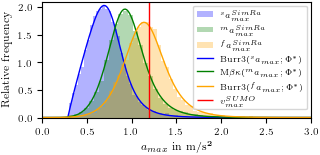

In [43]:
# plots for a_max

#plt.figure(figsize=(10,8))
#rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 16})
#rc('text', usetex=True)
plt.hist(pdf_acc_0['max_accel'], bins=65, density=True, label=r'$^{s}a_{max}^{SimRa}$', alpha=0.3, color='blue')
plt.hist(pdf_acc_1['max_accel'], bins=65, density=True, label=r'$^{m}a_{max}^{SimRa}$', alpha=0.3, color='green')
plt.hist(pdf_acc_2['max_accel'], bins=65, density=True, label=r'$^{f}a_{max}^{SimRa}$', alpha=0.3, color='orange')

# burr: statistic=0.006872481395881702, pvalue=0.670274585635346, param=(5.555017473724288, 0.3472125253420125, 0.2890578421354373, 0.5730493867811146)
a0, b0, c0, d0 = scipy.stats.burr.fit(pdf_acc_0['max_accel']) # 0 a_max -> burr (4 params)
# mielke: statistic=0.0043266880722089285, pvalue=0.7416766368222676, param=(5.622196601013915, 7.835472193275419, 0.04589095584641944, 0.953196030010006)
a1, b1, c1, d1 = scipy.stats.mielke.fit(pdf_acc_1['max_accel']) # 1 a_max -> mielke (4 params)
# burr: statistic=0.007993902948066123, pvalue=0.4080951882253737, param=(9.336613794008368, 0.6581541735079106, -0.025745072542825417, 1.2570925123823815)
a2, b2, c2, d2 = scipy.stats.burr.fit(pdf_acc_2['max_accel']) # 2 a_max -> johnsonsu (4 params)
x = np.linspace(0, 16, 1000)
# Burr Type III
y0 = scipy.stats.burr.pdf(x, a0, b0, c0, d0)
# Mielke Beta-Kappa distribution
y1 = scipy.stats.mielke.pdf(x, a1, b1, c1, d1)
# Burr Type III
y2 = scipy.stats.burr.pdf(x, a2, b2, c2, d2)
# Burr Type III
plt.plot(x, y0, linewidth=1, label='Burr3(' + r'$^{s}a_{max}; \Phi^*$' + ')', color='blue')
# Mielke Beta-Kappa
plt.plot(x, y1, linewidth=1, label='M' + r'$\beta\kappa$' + '(' + r'$^{m}a_{max}; \Phi^*$' + ')', color='green')
# Burr Type III
plt.plot(x, y2, linewidth=1, label='Burr3(' + r'$^{f}a_{max}; \Phi^*$' + ')', color='orange')
plt.xlabel(r'$a_{max}$ in m/s²')
plt.ylabel('Relative frequency')
plt.vlines(1.2, 0, 4, colors='r', linewidth=1, label=r'$v_{max}^{SUMO}$')
plt.xlim(0, 3)
plt.ylim(0, 2.1)

plt.legend()

print("0:{}{}{}{}".format(a0,b0,c0,d0))
print("1:{}{}{}".format(a1,b1,c1))
print("2:{}{}{}{}".format(a2,b2,c2,d2))

# print(scipy.stats.nct.cdf(5.56, a0, b0, loc0, scale0))
# print(scipy.stats.nct.cdf(25 / 3.6, a0, b0, loc0, scale0)) #
#
# print(scipy.stats.kstest(pdf_max_0['max_speed'], 'nct', args=(a0, b0, loc0, scale0)))
# print(a0, b0, loc0, scale0)
# print(scipy.stats.nct.ppf(0.05, a0, b0, loc0, scale0))
# print(scipy.stats.nct.ppf(0.95, a0, b0, loc0, scale0))
params.update(**pdf_params)
plt.rcParams.update(params)
plt.savefig("images/a_max_groups_dist_rel_new.pdf", bbox_inches='tight')

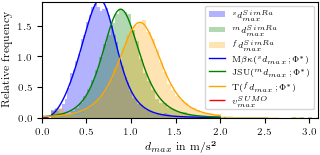

In [44]:
# plots for d_max

# plt.figure(figsize=(10,8))
# rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 16})
# rc('text', usetex=True)
# plt.hist(pdf_dec_all['max_decel'], bins=65, density=True, label=r'$d_{max}^{SimRa}$', alpha=0.3)
plt.hist(pdf_dec_0_abs, bins=65, density=True, label=r'$^{s}d_{max}^{SimRa}$', alpha=0.3, color='blue')
plt.hist(pdf_dec_1_abs, bins=65, density=True, label=r'$^{m}d_{max}^{SimRa}$', alpha=0.3, color='green')
plt.hist(pdf_dec_2_abs, bins=65, density=True, label=r'$^{f}d_{max}^{SimRa}$', alpha=0.3, color='orange')


# mielke: statistic=0.007555679559337336, pvalue=0.44933098003729877, param=(2.901719645161922, 6.802032927385836, 0.040503337047000466, 0.7461350530601983)
a0, b0, c0, d0 = scipy.stats.mielke.fit(pdf_dec_0_abs) # d_max -> mielke (4 params)
# johnsonsu: statistic=0.008178924267387866, pvalue=0.060365286376732996, param=(-0.21159087056428405, 1.7373176656481535, 0.8419577944018076, 0.39320920283067984)
a1, b1, c1, d1 = scipy.stats.johnsonsu.fit(pdf_dec_1_abs) # d_max -> johnsonsu (4 params)
# t: statistic=0.007472674589500454, pvalue=0.46208686802159027, param=(4.743774507126071, 1.0986491780498964, 0.2481157115171918)
a2, b2, c2 = scipy.stats.t.fit(pdf_dec_2_abs) # d_max -> t (3 params)

x = np.linspace(0, 2, 1000)
y0 = scipy.stats.mielke.pdf(x, a0, b0, c0, d0)
y1 = scipy.stats.johnsonsu.pdf(x, a1, b1, c1, d1)
y2 = scipy.stats.t.pdf(x, a2, b2, c2)
# Mielke Beta-Kappa
plt.plot(x, y0, linewidth=1, label='M' + r'$\beta\kappa$' + '(' + r'$^{s}d_{max}; \Phi^*$' + ')', color='blue')
# Johnson SU
plt.plot(x, y1, linewidth=1, label='JSU(' + r'$^{m}d_{max}; \Phi^*$' + ')', color='green')
# Student's t-distribution (or simply the t-distribution)
plt.plot(x, y2, linewidth=1, label='T(' + r'$^{f}d_{max}; \Phi^*$' + ')', color='orange')
plt.xlabel(r'$d_{max}$ in m/s²')
plt.ylabel('Relative frequency')
plt.vlines(0, 3.1, 10, colors='r', linewidth=1, label=r'$v_{max}^{SUMO}$')
plt.xlim(0,3.1)
plt.ylim(0, 1.9)

plt.legend()

# print(scipy.stats.nct.cdf(5.56, a0, b0, loc0, scale0))
# print(scipy.stats.nct.cdf(25 / 3.6, a0, b0, loc0, scale0)) #
#
# print(scipy.stats.kstest(pdf_max_0['max_speed'], 'nct', args=(a0, b0, loc0, scale0)))
# print(a0, b0, loc0, scale0)
# print(scipy.stats.nct.ppf(0.05, a0, b0, loc0, scale0))
# print(scipy.stats.nct.ppf(0.95, a0, b0, loc0, scale0))
params.update(**pdf_params)
plt.rcParams.update(params)
plt.savefig("images/d_max_groups_dist_rel_new.pdf", bbox_inches='tight')

In [45]:
# Find the best distribution for all rides v_max

list_of_dists_for_v_max = ['beta', 'betaprime', 'bradford', 'burr', 'burr12', 'cauchy', 'chi', 'chi2', 'cosine', 'dgamma', 'dweibull', 'erlang', 'expon', 'exponnorm', 'exponweib', 'exponpow', 'f', 'fatiguelife', 'fisk', 'foldcauchy', 'foldnorm', 'genlogistic', 'genpareto', 'gennorm', 'genexpon', 'genextreme', 'gausshyper', 'gamma', 'gengamma', 'genhalflogistic', 'gilbrat', 'gompertz', 'gumbel_r', 'gumbel_l', 'halfcauchy', 'halflogistic', 'halfnorm', 'halfgennorm', 'hypsecant', 'invgamma', 'invgauss', 'invweibull', 'johnsonsb', 'johnsonsu', 'kstwobign', 'laplace', 'levy', 'levy_l', 'logistic', 'loggamma', 'loglaplace', 'lognorm', 'lomax', 'maxwell', 'mielke', 'nakagami', 'ncx2', 'ncf', 'nct', 'norm', 'pareto', 'pearson3', 'powerlaw', 'powerlognorm', 'powernorm', 'rdist', 'reciprocal', 'rayleigh', 'rice', 'recipinvgauss', 'semicircular', 't', 'triang', 'truncexpon', 'truncnorm', 'tukeylambda', 'uniform', 'vonmises', 'vonmises_line', 'wald', 'weibull_min', 'weibull_max']

results=[]
def parallel_p(i):
    try:
        dist = getattr(scipy.stats, i)
        param = dist.fit(pdf_max_all['max_speed'])
        a0 = scipy.stats.kstest(pdf_max_all['max_speed'], i, args=param)
        # print("{}: statistic={}, pvalue={}".format(i, a[0], a[1]))
        return (i, a0[0], a0[1], param)
    except ValueError as e:
        print("      error type {} for {}".format(e,i))
        return None

p = Pool(None, limit_cpu)
results = [val for val in p.map(parallel_p, list_of_dists_for_v_max) if val != None]

results.sort(key=lambda x:float(x[2]), reverse=True)
gv = results[0]
for j in range (0,2):
    print("{}: statistic={}, pvalue={}, param={}".format(results[j][0], results[j][1], results[j][2], results[j][3]))
# for j in results:
#     print("{}: statistic={}, pvalue={}, param={}".format(j[0], j[1], j[2], j[3]))

gennorm: statistic=0.006146315991977236, pvalue=0.030160586984060545, param=(1.653118495038659, 6.761851020470841, 1.9602793200747795)
johnsonsu: statistic=0.008537178061158501, pvalue=0.0006131685550513796, param=(-0.15264851394611606, 3.0152139622254657, 6.52927278012519, 4.440903611890003)


In [46]:
 # Find the best distribution for all rides a_max

list_of_dists_for_a_max = ['alpha', 'anglit', 'arcsine', 'beta', 'betaprime', 'bradford', 'burr', 'burr12', 'cauchy', 'chi', 'chi2', 'cosine', 'dgamma', 'dweibull', 'erlang', 'expon', 'exponnorm', 'exponweib', 'exponpow', 'f', 'fatiguelife', 'fisk', 'foldcauchy', 'foldnorm', 'genlogistic', 'genpareto', 'gennorm', 'genexpon', 'genextreme', 'gausshyper', 'gamma', 'gengamma', 'genhalflogistic', 'gilbrat', 'gompertz', 'gumbel_r', 'gumbel_l', 'halfcauchy', 'halflogistic', 'halfnorm', 'halfgennorm', 'hypsecant', 'invgamma', 'invgauss', 'invweibull', 'johnsonsb', 'johnsonsu', 'kstwobign', 'laplace', 'levy', 'levy_l', 'logistic', 'loggamma', 'loglaplace', 'lognorm', 'lomax', 'maxwell', 'mielke', 'nakagami', 'ncx2', 'ncf', 'nct', 'norm', 'pareto', 'pearson3', 'powerlaw', 'powerlognorm', 'powernorm', 'rdist', 'reciprocal', 'rayleigh', 'rice', 'recipinvgauss', 'semicircular', 't', 'triang', 'truncexpon', 'truncnorm', 'tukeylambda', 'uniform', 'vonmises', 'vonmises_line', 'wald', 'weibull_min', 'weibull_max']
results=[]
def parallel_p(i):
    try:
        dist = getattr(scipy.stats, i)
        param = dist.fit(pdf_acc_all['max_accel'])
        a0 = scipy.stats.kstest(pdf_acc_all['max_accel'], i, args=param)
        # print("{}: statistic={}, pvalue={}".format(i, a[0], a[1]))
        return (i, a0[0], a0[1], param)
    except ValueError as e:
        print("      error type {} for {}".format(e,i))
        return None

p = Pool(None, limit_cpu)
results = [val for val in p.map(parallel_p, list_of_dists_for_a_max) if val != None]

results.sort(key=lambda x:float(x[2]), reverse=True)
ga = results[0]
for j in range (0,2):
    print("{}: statistic={}, pvalue={}, param={}".format(results[j][0], results[j][1], results[j][2], results[j][3]))
# for j in results:
#     print("{}: statistic={}, pvalue={}, param={}".format(j[0], j[1], j[2], j[3]))

burr12: statistic=0.006230962164058496, pvalue=0.04035106735099048, param=(3.707469432713943, 2.964667723834678, 0.15008150635568956, 1.1269885432797884)
exponnorm: statistic=0.007335088666975048, pvalue=0.008958395617397226, param=(0.8940388372801467, 0.7661045188410415, 0.21484888240640737)


In [47]:
# Find the best distribution for all rides d_max
list_of_dists_for_d_max = ['powernorm','norm','exponnorm','beta','betaprime','bradford','burr','burr12','cauchy','chi','chi2','cosine','dgamma','dweibull','erlang','expon','exponnorm','exponweib','exponpow','f','fatiguelife','fisk','foldcauchy','foldnorm','genlogistic','genpareto','gennorm','genexpon','genextreme','gausshyper','gamma','gengamma','genhalflogistic','gilbrat','gompertz','gumbel_r','gumbel_l','halfcauchy','halflogistic','halfnorm','halfgennorm','hypsecant','invgamma','invgauss','invweibull','johnsonsb','johnsonsu','kstwobign','laplace','levy','levy_l','logistic','loggamma','loglaplace','lognorm','lomax','maxwell','mielke','nakagami','ncx2','ncf','nct','norm','pareto','pearson3','powerlaw','powerlognorm','powernorm','rdist','reciprocal','rayleigh','rice','recipinvgauss','semicircular','t','triang','truncexpon','truncnorm','tukeylambda','uniform','vonmises','vonmises_line','wald','weibull_min','weibull_max']
results=[]
pdf_dec_all_abs = pdf_dec_all['max_decel'][lambda x: x < 0].abs()
def parallel_p(i):
    try:
        dist = getattr(scipy.stats, i)
        param = dist.fit(pdf_dec_all_abs)
        a0 = scipy.stats.kstest(pdf_dec_all_abs, i, args=param)
        # print("{}: statistic={}, pvalue={}".format(i, a[0], a[1]))
        return (i, a0[0], a0[1], param)
    except ValueError as e:
        print("      error type {} for {}".format(e,i))
        return None

p = Pool(None, limit_cpu)
results = [val for val in p.map(parallel_p, list_of_dists_for_d_max) if val != None]

results.sort(key=lambda x:float(x[2]), reverse=True)
gd = results[0]
for j in range (0,2):
    print("{}: statistic={}, pvalue={}, param={}".format(results[j][0], results[j][1], results[j][2], results[j][3]))
# for j in results:
#     print("{}: statistic={}, pvalue={}, param={}".format(j[0], j[1], j[2], j[3]))

mielke: statistic=0.005801937418045869, pvalue=0.05251964158251021, param=(3.10241154496342, 7.6153609724126206, -0.03151322487179187, 1.1140553579979193)
burr: statistic=0.005824990943625125, pvalue=0.051020239134923706, param=(7.612976480950529, 0.40688516999739666, -0.030679704189408158, 1.113488765465275)


In [87]:
def generate_line(name, dist):
    dist_obj = getattr(scipy.stats, dist[0])
    return f"{name}; {dist[0]}({', '.join(['{:.4f}'.format(x) for x in dist[3]])}); [{'{:.4f}'.format(dist_obj.ppf(0.05, *dist[3]))},{'{:.4f}'.format(dist_obj.ppf(0.95, *dist[3]))}]"

def generate_config(group_name, vdist, adist, ddist):
    a = generate_line('accel', adist)
    v = generate_line('maxSpeed', vdist)
    d = generate_line('decel', ddist)
    with open(f"../../parameterization_impl/config_{group_name}.txt", "w") as file:
        file.writelines("\n".join([
        a,
        v,
        d,
        "speedDev; 0",
        "speedFactor; 4",
        "param; has.fcd.device; true",
        "vClass; bicycle"
        ]))
generate_config("slow", g0v, g0a, g0d)
generate_config("medium", g1v, g1a, g1d)
generate_config("fast", g2v, g2a, g2d)
generate_config("all", gv, ga, gd)

# gev, gea, ged

#print(locals()["pdf_dec_2_abs"])
#print(g0v)
#generate_line('test', g0v)

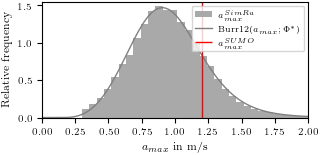

In [48]:
# plot for all rides a_max

# plt.figure(figsize=(10,8))
#nrc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 16})
#nrc('text', usetex=True)
plt.hist(pdf_acc_all['max_accel'], bins=65, density=True, label=r'$a_{max}^{SimRa}$', color='darkgrey')
# burr12: statistic=0.006628657832739471, pvalue=0.02899814282896107, param=(3.7084928118467992, 2.8837466199346977, 0.14944903718235975, 1.1162959144580862)
a0, b0, c0, d0 = scipy.stats.burr12.fit(pdf_acc_all['max_accel']) # 0 v_max -> burr12 (4 params)
x = np.linspace(0, 16, 1000)
y0 = scipy.stats.burr12.pdf(x, a0, b0, c0, d0)
# Burr 12
plt.plot(x, y0, linewidth=1, label='Burr12(' + r'$a_{max}; \Phi^*$' + ')', color='grey')
plt.xlabel(r'$a_{max}$ in m/s')
plt.ylabel('Relative frequency')
plt.vlines(1.2, 0, 4, colors='r', linewidth=1, label=r'$a_{max}^{SUMO}$')
plt.xlim(0, 2)
plt.ylim(0, 1.55)

plt.legend()

# print(scipy.stats.nct.cdf(5.56, a0, b0, loc0, scale0))
# print(scipy.stats.nct.cdf(25 / 3.6, a0, b0, loc0, scale0)) #
#
# print(scipy.stats.kstest(pdf_max_0['max_speed'], 'nct', args=(a0, b0, loc0, scale0)))
# print(a0, b0, loc0, scale0)
# print(scipy.stats.nct.ppf(0.05, a0, b0, loc0, scale0))
# print(scipy.stats.nct.ppf(0.95, a0, b0, loc0, scale0))
params.update(**pdf_params)
plt.rcParams.update(params)
plt.savefig("images/a_max_all_dist_rel_new.pdf", bbox_inches='tight')

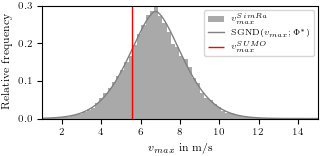

In [49]:
# plot for all rides v_max

# plt.figure(figsize=(10,8))
# rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 16})
# rc('text', usetex=True)
plt.hist(pdf_max_all['max_speed'], bins=65, density=True, label=r'$v_{max}^{SimRa}$', color='darkgrey')
# gennorm: statistic=0.005261780945291061, pvalue=0.10375834745304324, param=(1.6418252086391243, 6.770793122539128, 1.9503475146099707)
a0, b0, c0 = scipy.stats.gennorm.fit(pdf_max_all['max_speed']) # 0 v_max -> gennorm (3 params)
x = np.linspace(0, 16, 1000)
y0 = scipy.stats.gennorm.pdf(x, a0, b0, c0)
# symmetric generalized normal distribution
plt.plot(x, y0, linewidth=1, label='SGND(' + r'$v_{max}; \Phi^*$' + ')', color='grey')
plt.xlabel(r'$v_{max}$ in m/s')
plt.ylabel('Relative frequency')
plt.vlines(5.56, 0, 4, colors='r', linewidth=1, label=r'$v_{max}^{SUMO}$')
plt.xlim(1, 15)
plt.ylim(0, 0.30)

plt.legend()
params.update(**pdf_params)
plt.rcParams.update(params)
plt.savefig("images/v_max_all_dist_rel_new.pdf", bbox_inches='tight')

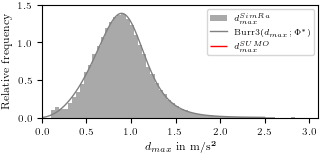

In [50]:
# plots for d_max

# plt.figure(figsize=(10,8))
# rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 16})
# rc('text', usetex=True)
pdf_dec_all_abs = pdf_dec_all['max_decel'][lambda x: x < 0].abs()
plt.hist(pdf_dec_all_abs, bins=65, density=True, label=r'$d_{max}^{SimRa}$', color='darkgrey')

# burr: statistic=0.005755134401537368, pvalue=0.0635345959768574, param=(7.400171455971577, 0.4049732162907138, -0.013546006112654982, 1.0956217511881536)
a, b, c, d = scipy.stats.burr.fit(pdf_dec_all_abs) # d_max -> burr (4 params)
x = np.linspace(0, 2.5, 1000)
y = scipy.stats.burr.pdf(x, a, b, c, d)
# Burr Type III
plt.plot(x, y, linewidth=1, label='Burr3(' + r'$d_{max}; \Phi^*$' + ')', color='grey')
plt.xlabel(r'$d_{max}$ in m/s²')
plt.ylabel('Relative frequency')
plt.vlines(0, 3, 10, colors='r', linewidth=1, label=r'$d_{max}^{SUMO}$')
plt.xlim(0, 3.1)
plt.ylim(0, 1.5)

plt.legend()
params.update(**pdf_params)
plt.rcParams.update(params)
plt.savefig("images/d_max_all_dist_rel_new.pdf", bbox_inches='tight')

# print(scipy.stats.nct.cdf(5.56, a0, b0, loc0, scale0))
# print(scipy.stats.nct.cdf(25 / 3.6, a0, b0, loc0, scale0)) #
#
# print(scipy.stats.kstest(pdf_max_0['max_speed'], 'nct', args=(a0, b0, loc0, scale0)))
# print(a0, b0, loc0, scale0)
# print(scipy.stats.nct.ppf(0.05, a0, b0, loc0, scale0))
# print(scipy.stats.nct.ppf(0.95, a0, b0, loc0, scale0))

0.6856549146193583
0.9582585144805771
KstestResult(statistic=0.026895923317583226, pvalue=3.6578694834668207e-09, statistic_location=4.62179106825834, statistic_sign=-1)
339.87938841273365 5.149402211149772 -0.469004981566594 1.0673858019136926
3.2587441768599383
6.847896158041025


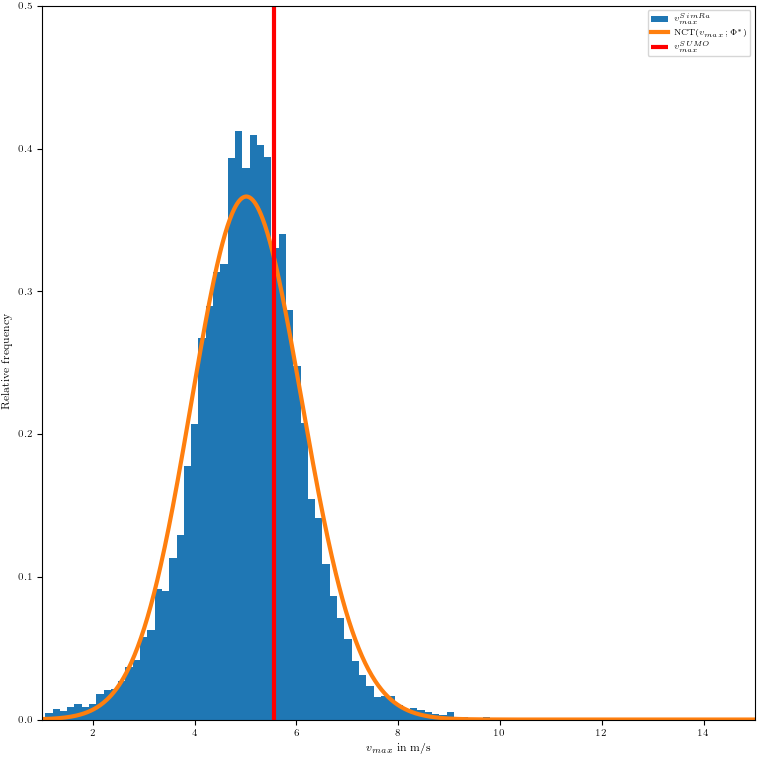

In [51]:
plt.figure(figsize=(8,8))
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 16})
rc('text', usetex=True)
plt.hist(pdf_max_0['max_speed'], bins=65, density=True, label=r'$v_{max}^{SimRa}$')

a0, b0, loc0, scale0 = scipy.stats.nct.fit(pdf_max_0['max_speed'])
x = np.linspace(0, 16, 1000)
y0 = scipy.stats.nct.pdf(x, a0, b0, loc0, scale0)
plt.plot(x, y0, linewidth=3, label='NCT(' + r'$v_{max}; \Phi^*$' + ')')
plt.xlabel(r'$v_{max}$ in m/s')
plt.ylabel('Relative frequency')
plt.vlines(5.56, 0, 4, colors='r', linewidth=3, label=r'$v_{max}^{SUMO}$')
plt.xlim(1, 15)
plt.ylim(0, 0.5)

plt.legend()
plt.savefig("images/velo_max_v_avg_n.png", dpi=300, bbox_inches='tight')

print(scipy.stats.nct.cdf(5.56, a0, b0, loc0, scale0))
print(scipy.stats.nct.cdf(25 / 3.6, a0, b0, loc0, scale0)) #

print(scipy.stats.kstest(pdf_max_0['max_speed'], 'nct', args=(a0, b0, loc0, scale0)))
print(a0, b0, loc0, scale0)
print(scipy.stats.nct.ppf(0.05, a0, b0, loc0, scale0))
print(scipy.stats.nct.ppf(0.95, a0, b0, loc0, scale0))

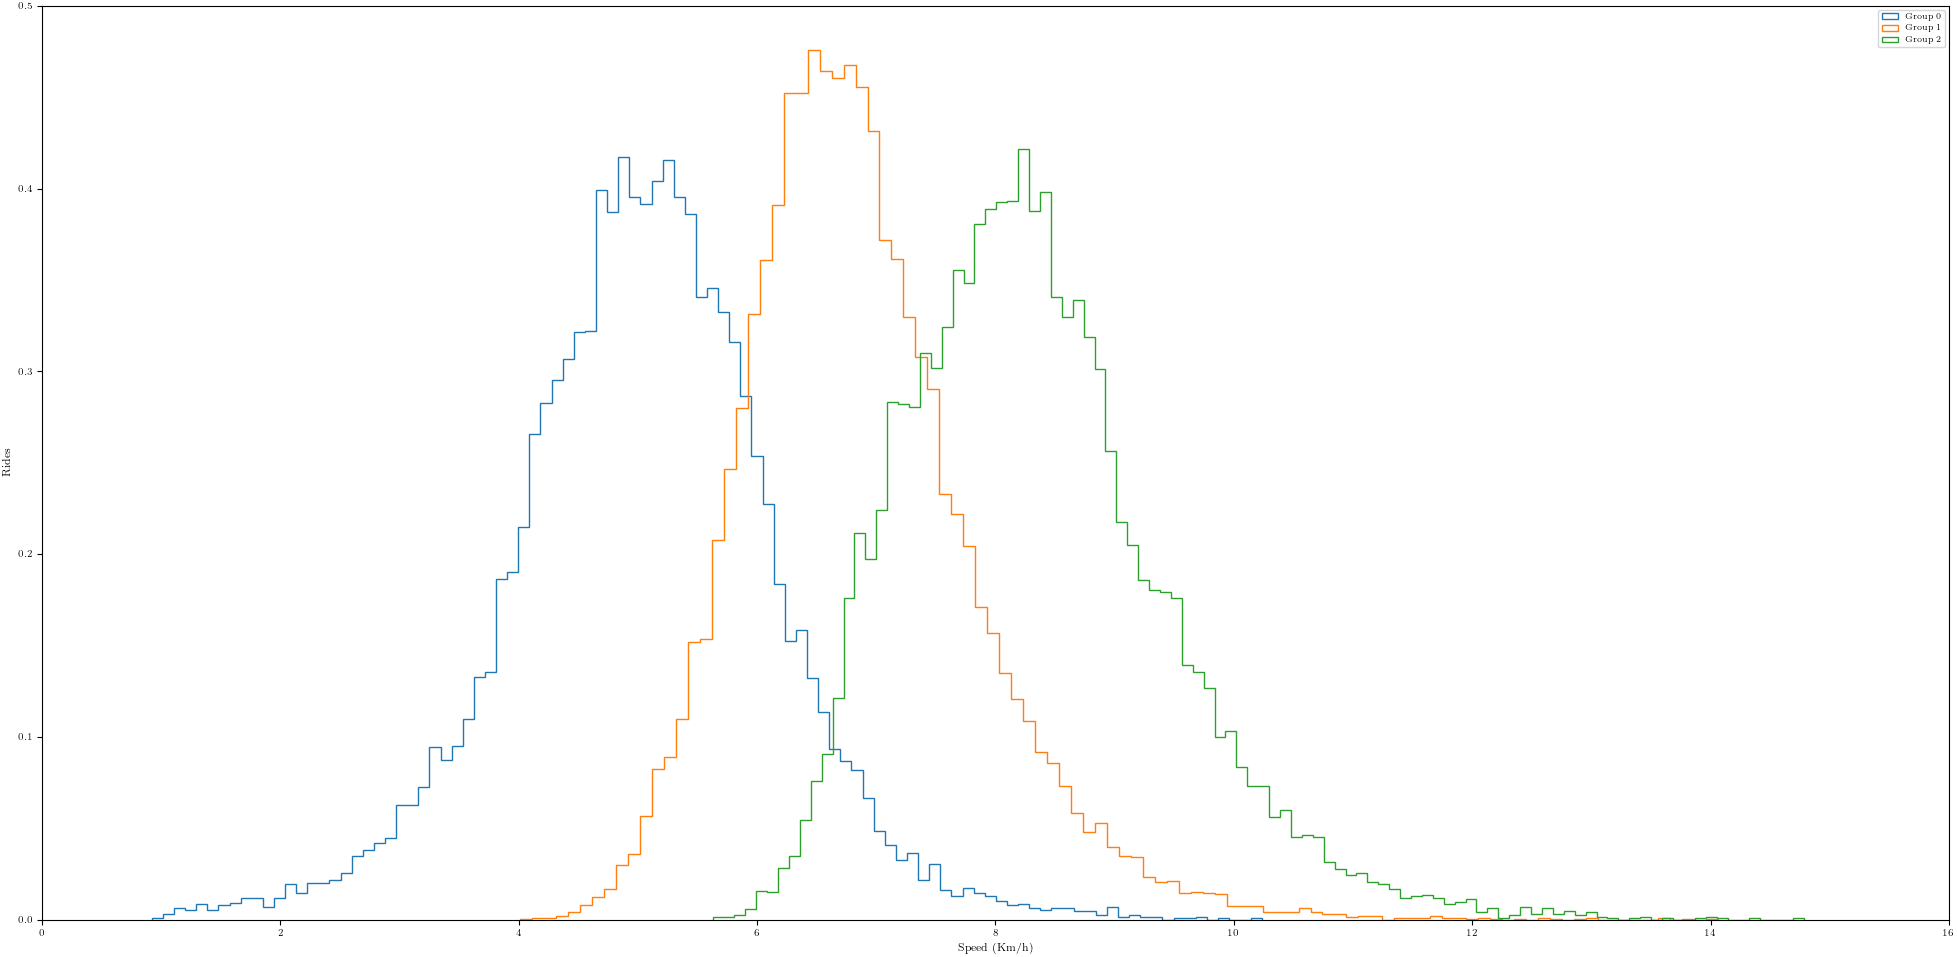

In [52]:
fig = plt.figure(figsize=[20, 10])

ax = plt.axes()
ax.set_ylabel('Rides')
ax.set_xlabel('Speed (Km/h)')

#plot_graph(pdf_avg_0['avg_speed'], "Group 0", False)
plot_graph(pdf_max_0['max_speed'], "Group 0", False, 100, True, 0, 16, 0, 0.5)

#plot_graph(pdf_avg_1['avg_speed'], "Group 1", False)
plot_graph(pdf_max_1['max_speed'], "Group 1", False, 100, True, 0, 16, 0, 0.5)

#plot_graph(pdf_avg_2['avg_speed'], "Group 2", False)
plot_graph(pdf_max_2['max_speed'], "Group 2", False, 100, True, 0, 16, 0, 0.5)

plt.legend()
plt.show()

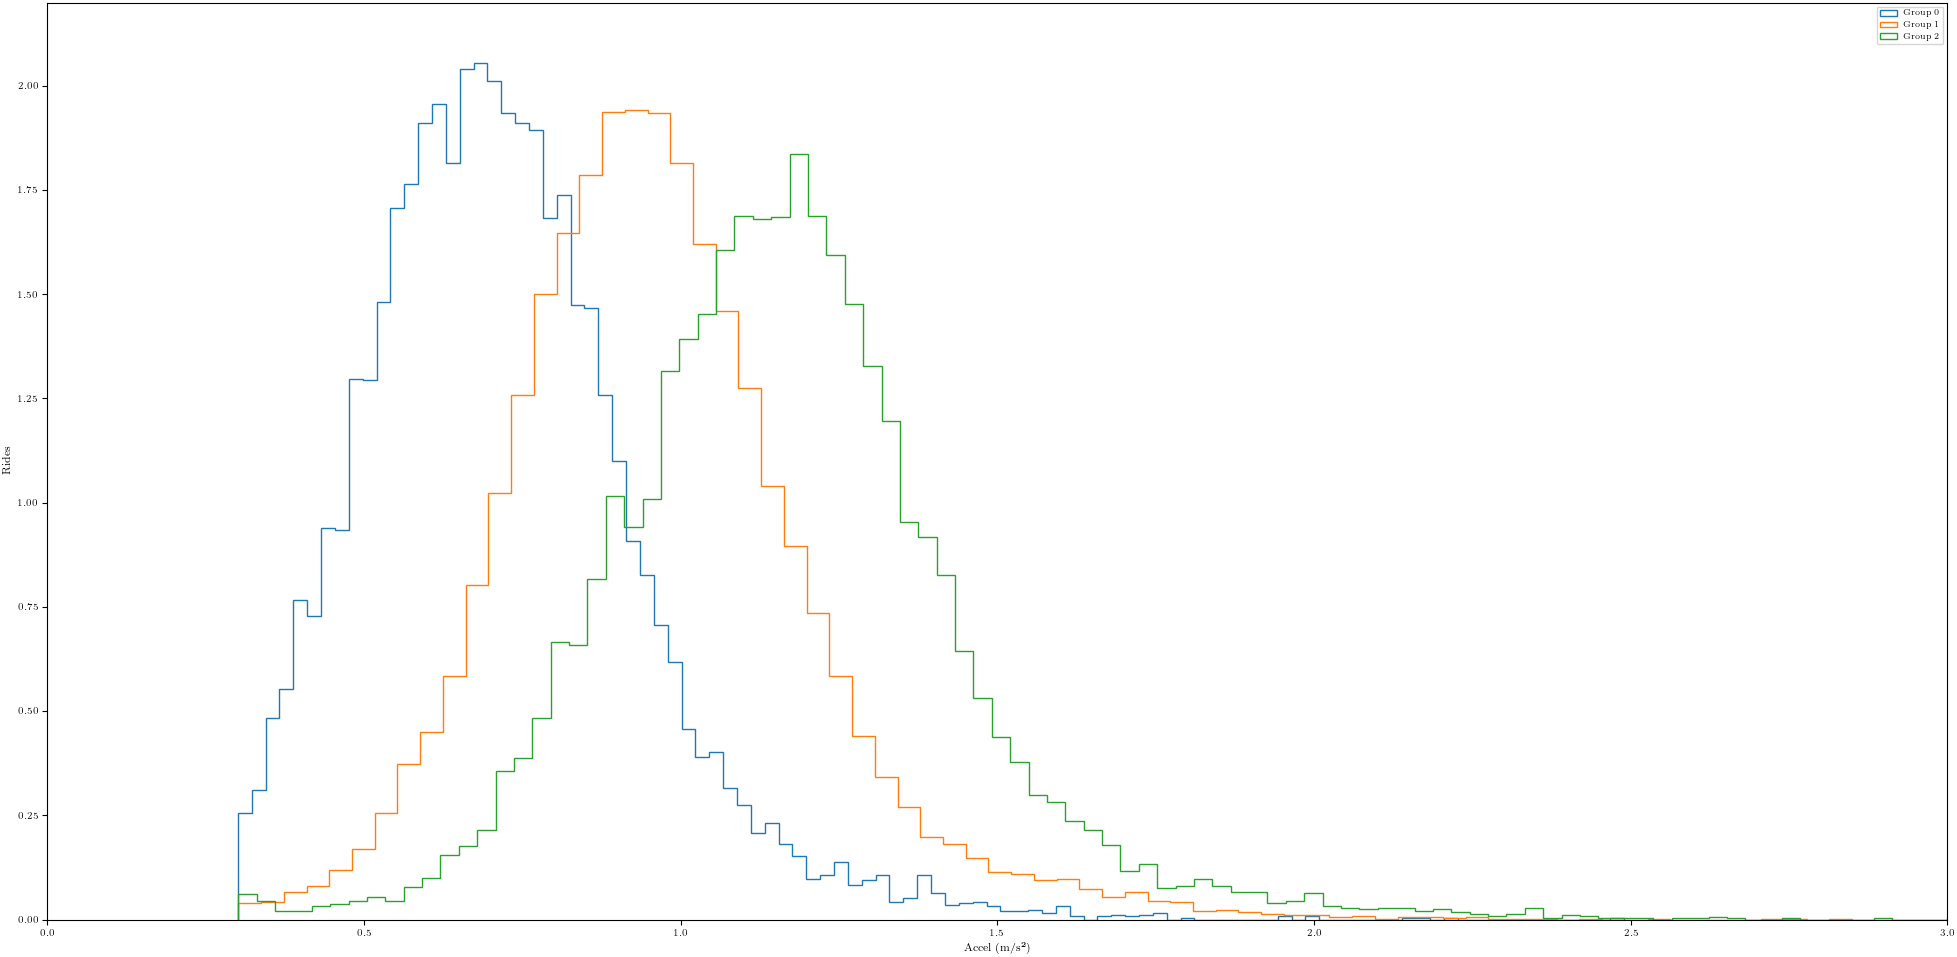

In [53]:
fig = plt.figure(figsize=[20, 10])

ax = plt.axes()
ax.set_ylabel('Rides')
ax.set_xlabel('Accel (m/s²)')

#plot_graph(pdf_all['max_accel'] / 3.6, "All", False)
plot_graph(pdf_acc_0['max_accel'], "Group 0", False, 100, True, 0, 3, 0, 2.2)
plot_graph(pdf_acc_1['max_accel'], "Group 1", False, 100, True, 0, 3, 0, 2.2)
plot_graph(pdf_acc_2['max_accel'], "Group 2", False, 100, True, 0, 3, 0, 2.2)

plt.legend()
plt.show()

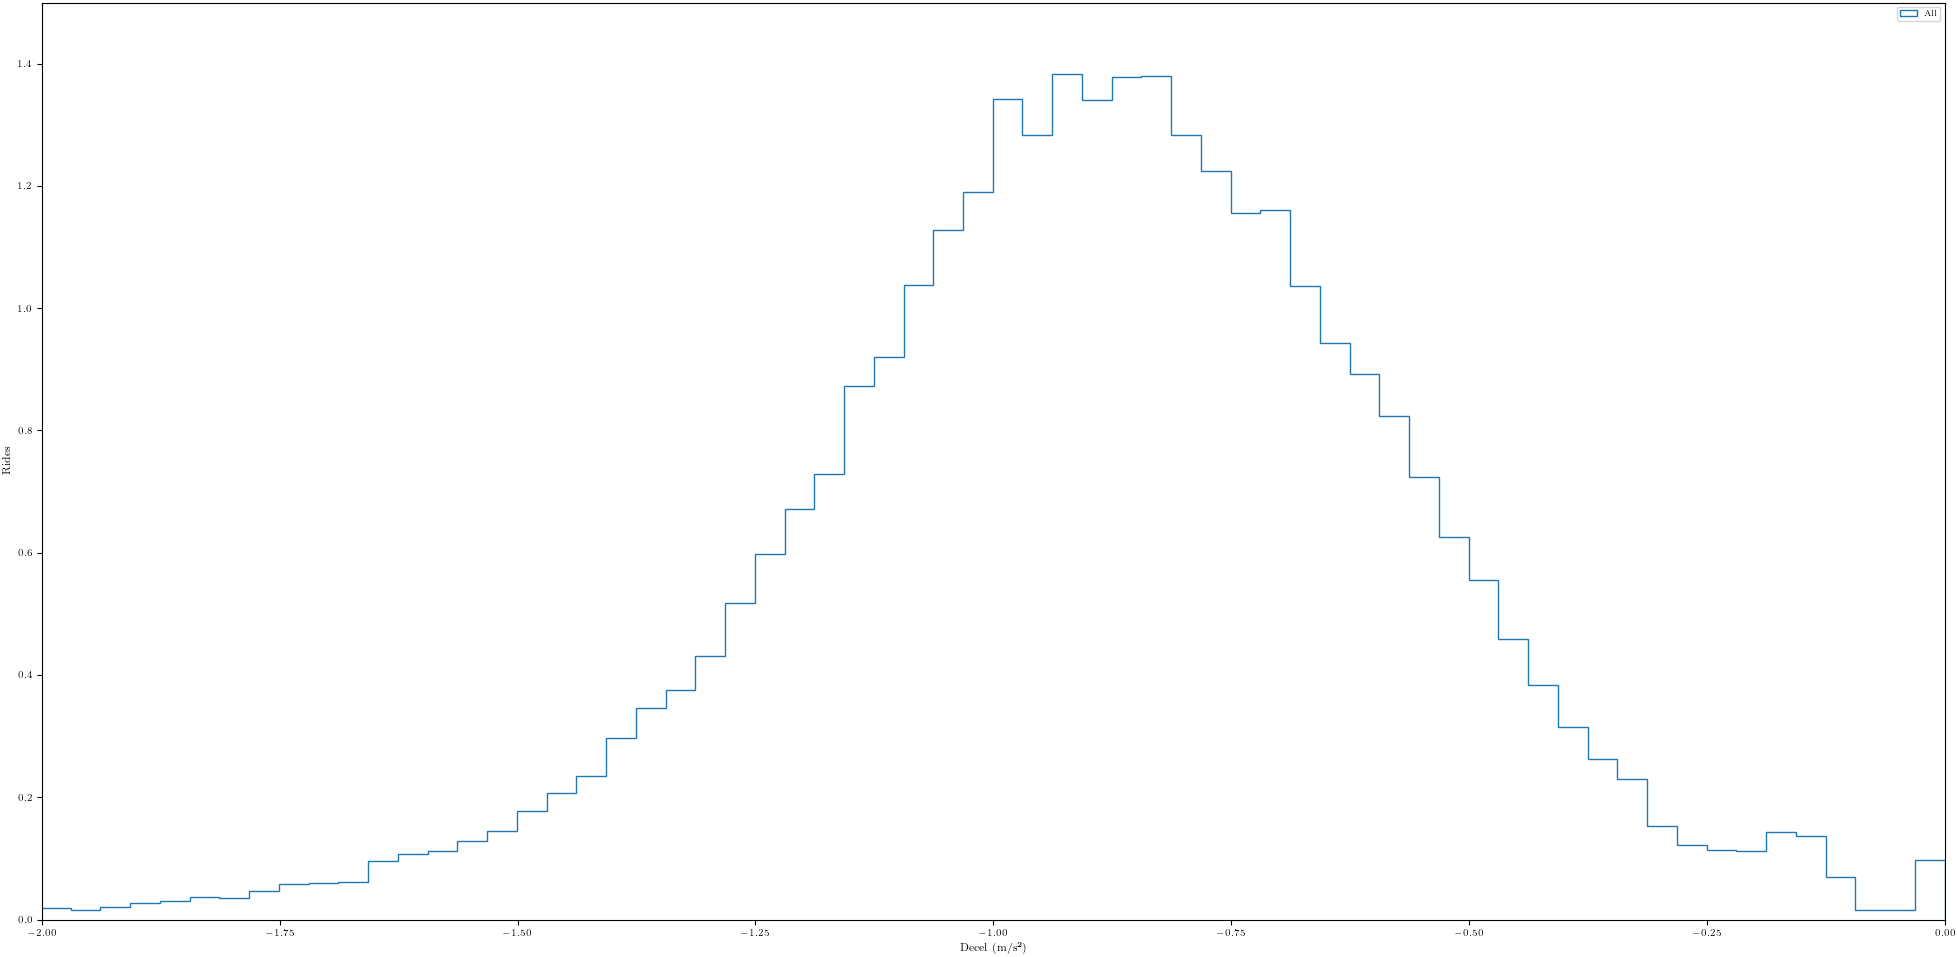

In [54]:
fig = plt.figure(figsize=[20, 10])

ax = plt.axes()
ax.set_ylabel('Rides')
ax.set_xlabel('Decel (m/s²)')
plt.xlim(-1.6, 0)

plot_graph(pdf_all['max_decel'][lambda x: x < 0], "All", False, 100, True, -2, 0, 0, 1.5)
#plot_graph(pdf_dec_0['max_decel'] / 3.6, "Group 0", False)
#plot_graph(pdf_dec_1['max_decel'] / 3.6, "Group 1", False)
#plot_graph(pdf_dec_2['max_decel'] / 3.6, "Group 2", False)

plt.legend()
plt.show()

In [3]:
with DatabaseConnection() as cur:
    cur.execute("""

        SELECT two.fn, two.ts, two.ve FROM (
        SELECT one.fn as fn, unnest(one.t) as ts, unnest(one.v) as ve FROM (
        SELECT filename as fn, timestamps as t, distances as d, velos as v, (((ST_Points(geom::geometry))::json) -> 'coordinates') as pts from ride OFFSET 9 LIMIT 1
        ) as one
        ) as two WHERE two.ve != 'NaN' AND two.ve < 15 ORDER BY two.ts ASC

    """)
    objs_one = cur.fetchall()

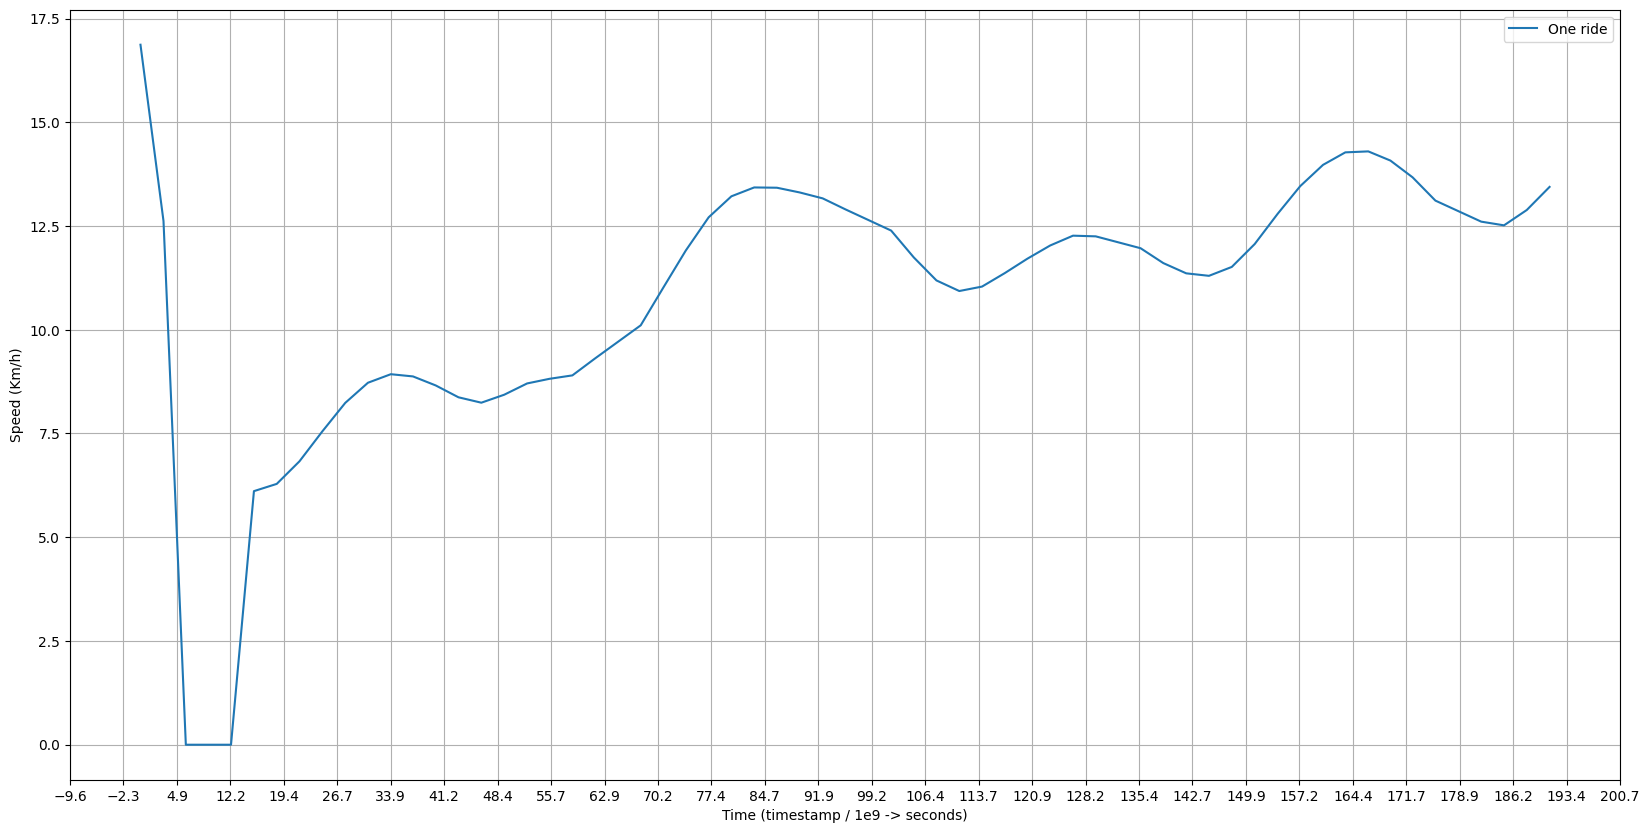

In [4]:
pdf_one = pd.DataFrame(objs_one, columns=['file', 'time', 'speed'])

fig = plt.figure(figsize=[20, 10])

ax = plt.axes()
ax.grid()
ax.xaxis.set_major_locator(ticker.LinearLocator(numticks=30))
ax.set_ylabel('Speed (Km/h)')
ax.set_xlabel('Time (timestamp / 1e9 -> seconds)')
#plt.xlim(0, 200)

plt.plot(pdf_one['time'].map(lambda v: (v.value - pdf_one['time'][0].value) / 1e9), pdf_one['speed'] * 3.6, label="One ride")

plt.legend()
plt.show()

In [57]:
with DatabaseConnection() as cur:
    cur.execute("""

        SELECT three.fn, AVG(three.vf), AVG(three.vl) FROM (
        SELECT two.fn as fn, unnest(two.ve[1:3]) as vf, unnest(two.ve[array_length(two.ve, 1) - 2:array_length(two.ve, 1)]) as vl FROM (
        SELECT filename as fn, array_remove(velos, 'NaN') as ve FROM ride
        ) as two
        ) three GROUP BY three.fn

    """)
    objs_start_spd = cur.fetchall()

TypeError: plot_graph() missing 6 required positional arguments: 'n_bins', 'density', 'x_lim_0', 'x_lim_1', 'y_lim_0', and 'y_lim_1'

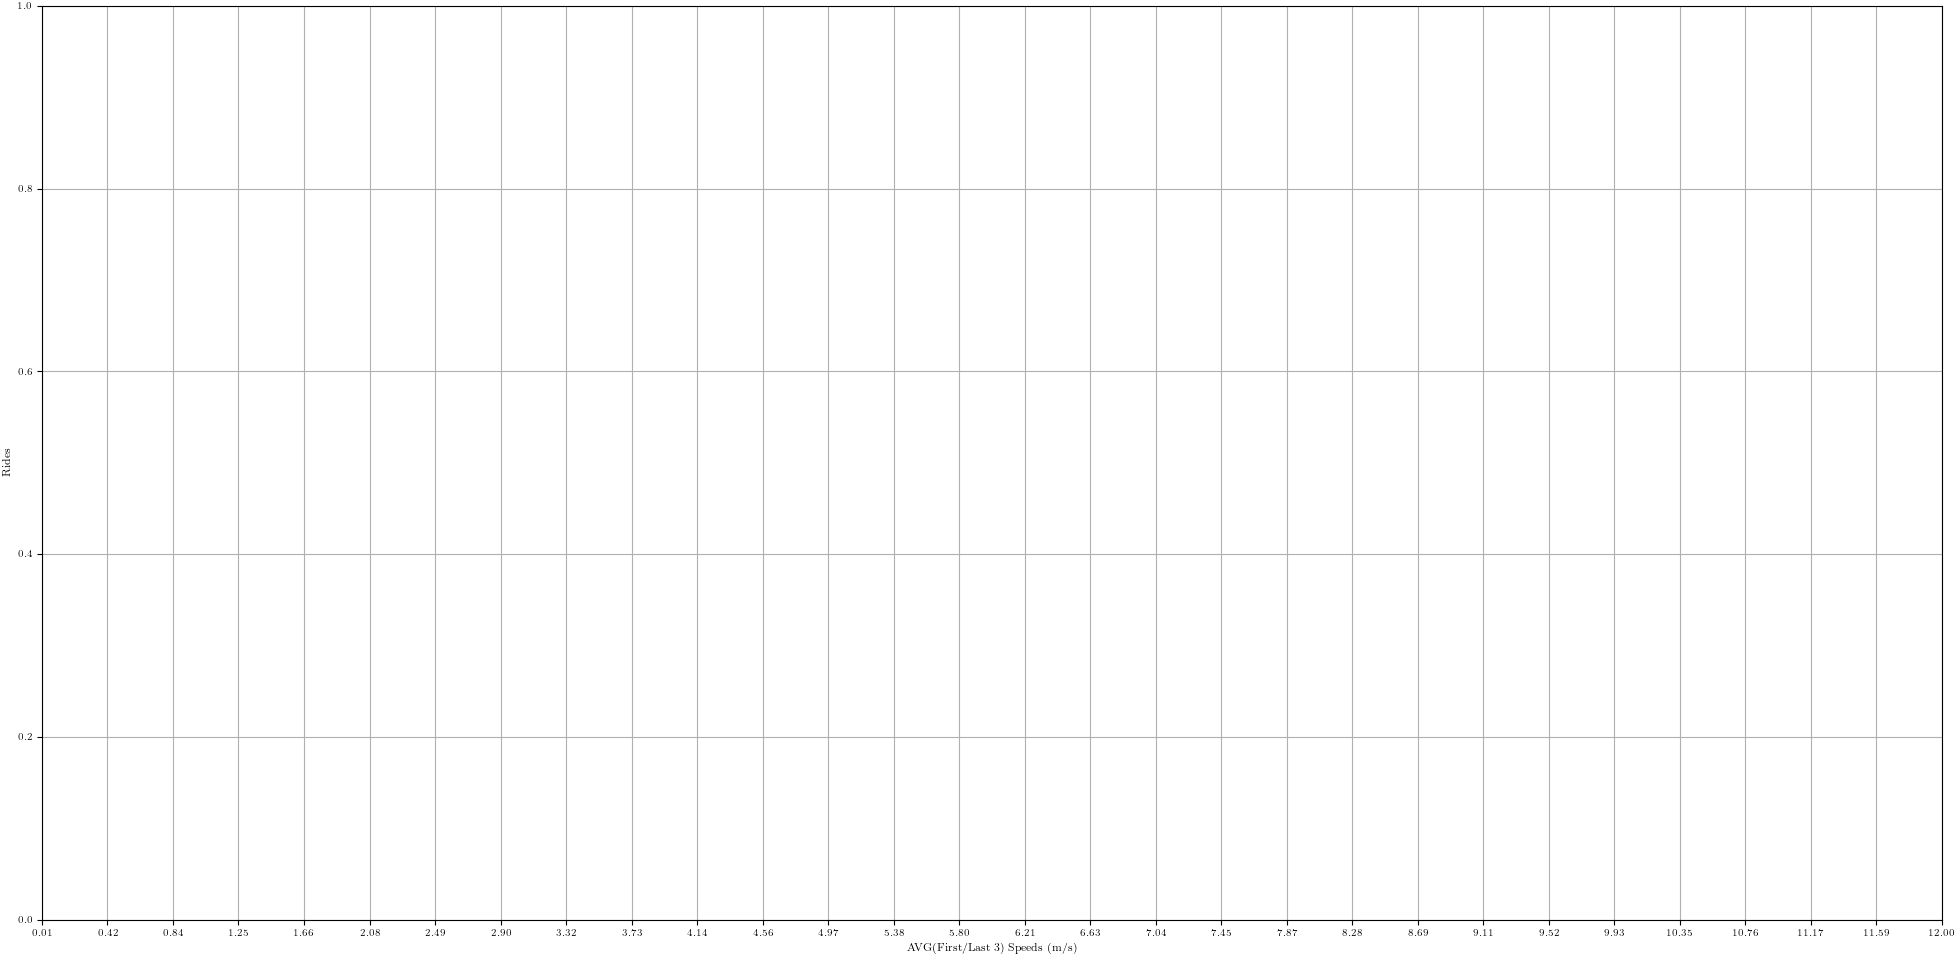

In [58]:
pdf_start_spd = pd.DataFrame(objs_start_spd, columns=['file', 'avg_speed_e', 'avg_speed_l'])

fig = plt.figure(figsize=[20, 10])

ax = plt.axes()
ax.grid()
ax.xaxis.set_major_locator(ticker.LinearLocator(numticks=30))
ax.set_ylabel('Rides')
ax.set_xlabel('AVG(First/Last 3) Speeds (m/s)')
plt.xlim(0.01, 12)

plot_graph(pdf_start_spd['avg_speed_e'], "AVG(First 3)", False)
plot_graph(pdf_start_spd['avg_speed_l'], "AVG(Last 3)", False)

plt.legend()
plt.show()

In [ ]:
with DatabaseConnection() as cur:
    cur.execute("""

        --SELECT two.fn, AVG(two.ve), MAX(two.ve),
        --    AVG(two.a) filter (WHERE two.a >= 0 AND two.a != 'NaN'), MAX(two.a) filter (WHERE two.a >= 0 AND two.a != 'NaN'),
        --    AVG(two.a) filter (WHERE two.a < 0 AND two.a != 'NaN'), MIN(two.a) filter (WHERE two.a < 0 AND two.a != 'NaN'),
        --    CASE WHEN AVG(two.ve) < 4.3638 THEN 0 ELSE CASE WHEN AVG(two.ve) < 5.6694 THEN 1 ELSE 2 END END
        --    FROM (
        --        SELECT filename as fn, unnest(timestamps) as ts, unnest(velos) as ve, unnest(accels) as a FROM ride
        --    ) as two WHERE two.ve > 0.2 AND two.ve != 'NaN' AND two.ve < 15 GROUP BY two.fn

        SELECT two.fn, AVG(two.ve), MAX(two.ve), AVG(a1.accel), MAX(a1.accel), AVG(d1.accel), MIN(d1.accel), CASE WHEN AVG(two.ve) < 4.3638 THEN 0 ELSE CASE WHEN AVG(two.ve) < 5.6694 THEN 1 ELSE 2 END END FROM (
        SELECT one.fn as fn, unnest(one.t) as ts, unnest(one.v) as ve FROM (
        SELECT filename as fn, timestamps as t, distances as d, velos as v, (((ST_Points(geom::geometry))::json) -> 'coordinates') as pts from ride
        ) as one
        ) as two LEFT JOIN accels a1 ON (two.fn = a1.filename AND two.ts = a1.timestamp AND a1.accel >= 0)
                 LEFT JOIN accels d1 ON (two.fn = d1.filename AND two.ts = d1.timestamp AND d1.accel < 0)
                 WHERE two.ve > 0.2 AND two.ve != 'NaN' AND two.ve < 15 GROUP BY two.fn

    """)
    objs_corr = cur.fetchall()

In [ ]:
from pyensae.graphhelper import Corrplot
import docutils
df_corr = pd.DataFrame(objs_corr, columns=['file', 'avg_speed', 'max_speed', 'avg_accel', 'max_accel', 'avg_decel', 'max_decel', 'group']).drop(columns=['file'])

c = Corrplot(df_corr)
c.plot(figsize=(20,10))

plt.show()

In [ ]:
import numpy as np
import scipy.stats as st

#pdf = pd.DataFrame(objs, columns=['file', 'velo']).query('velo > 0.2 and velo != "NaN" and velo < 15')

#groupd = pdf.groupby('file').aggregate({'velo': np.average}).rename(columns={'velo': 'avg_speed'})

#pdf = groupd #pdf.merge(groupd, how='inner', on='file')

print(objs[0])

# pdf_all = pd.DataFrame(objs, columns=['file', 'avg_speed', 'max_speed', 'max_accel', 'max_decel', 'group'])#.sort_values('avg_speed').reset_index()

pdf_all = pd.DataFrame(objs, columns=['file', 'avg_speed', 'max_speed', 'max_accel', 'max_decel', 'group']).query('max_accel != "NaN"')

pdf_avg_0 = pdf_all.query('group == 0')[['file', 'avg_speed']].sort_values('avg_speed').reset_index()
pdf_max_0 = pdf_all.query('group == 0')[['file', 'max_speed']].sort_values('max_speed').reset_index()
pdf_acc_0 = pdf_all.query('group == 0')[['file', 'max_accel']].sort_values('max_accel').reset_index()

pdf_avg_1 = pdf_all.query('group == 1')[['file', 'avg_speed']].sort_values('avg_speed').reset_index()
pdf_max_1 = pdf_all.query('group == 1')[['file', 'max_speed']].sort_values('max_speed').reset_index()
pdf_acc_1 = pdf_all.query('group == 1')[['file', 'max_accel']].sort_values('max_accel').reset_index()

pdf_avg_2 = pdf_all.query('group == 2')[['file', 'avg_speed']].sort_values('avg_speed').reset_index()
pdf_max_2 = pdf_all.query('group == 2')[['file', 'max_speed']].sort_values('max_speed').reset_index()
pdf_acc_2 = pdf_all.query('group == 2')[['file', 'max_accel']].sort_values('max_accel').reset_index()

b1 = 15.71#3.6 * pdf_avg.iloc[int(0.25 * len(pdf_avg))]['avg_speed']
b2 = 20.41#3.6 * pdf_avg.iloc[int(0.75 * len(pdf_avg))]['avg_speed']
#c1 = 3.6 * pdf_max.iloc[int(0.25 * len(pdf_max))]['max_speed']
#c2 = 3.6 * pdf_max.iloc[int(0.75 * len(pdf_max))]['max_speed']

print(b1)
print(b2)

#pdf_g = pd.DataFrame([[1, 2, 3], [1, 5, 6], [2, 2, 4], [2, 5, 7]], columns=['a', 'b', 'c'])

#groupd = pdf_g.groupby('a').aggregate({'b': np.average, 'c': np.average}).rename(columns={'b': 'b_avg', 'c': 'c_avg'})

#print(groupd.query('a == 1'))

#print(groupd)

#print(pdf_g.merge(groupd, how='inner', on='a'))

fig = plt.figure(figsize=[20, 10])

ax = plt.axes()
ax.grid()
ax.xaxis.set_major_locator(ticker.LinearLocator(numticks=30))
ax.set_ylabel('Rides')
#ax.set_xlabel('Speed (Km/h)')
ax.set_xlabel('Accel (m/s²)')

#ax.vlines([b1, b2], 0, 0.125)
#ax.vlines([c1, c2], 0, 0.125)

def plot_graph(pdf_local: pd.Series, vlines: bool):
    mn, mx = plt.xlim()
    n_bins = 200
    plt.hist(pdf_local, n_bins, range=(mn, mx), density=False, histtype='step')
    kde_xs = np.linspace(mn, mx, 200)
    kde_avg = st.gaussian_kde(pdf_local)
    plt.plot(kde_xs, ((mx - mn) / n_bins * len(pdf_local)) * kde_avg.pdf(kde_xs), label="PDF")

    if vlines:
        ax.vlines([pdf_local.iloc[int(0.25 * len(pdf_local))], pdf_local.iloc[int(0.75 * len(pdf_local))]], 0, 0.125)


#plt.hist(pdf_avg['avg_speed'] * 3.6, 200, density=True, histtype='step')
#plt.hist(pdf_max['max_speed'] * 3.6, 200, density=True, histtype='step')
#plt.plot(pdf.sort_values('avg_speed').reset_index()['avg_speed'])

#plt.ylim([0, 10])

#mn, mx = plt.xlim()
#plt.xlim(mn, mx)
plt.xlim(-0.1, 2)
#kde_xs = np.linspace(mn, mx, 200)
#kde_avg = st.gaussian_kde(pdf_avg['avg_speed'] * 3.6)
#kde_max = st.gaussian_kde(pdf_max['max_speed'] * 3.6)
#plt.plot(kde_xs, kde_avg.pdf(kde_xs), label="PDF")
#plt.plot(kde_xs, kde_max.pdf(kde_xs), label="PDF")

#plot_graph(pdf_avg_0['avg_speed'], False)
#plot_graph(pdf_max_0['max_speed'], False)
plot_graph(pdf_acc_0['max_accel'], False)

#plot_graph(pdf_avg_1['avg_speed'], False)
#plot_graph(pdf_max_1['max_speed'], False)
plot_graph(pdf_acc_1['max_accel'], False)

#plot_graph(pdf_avg_2['avg_speed'], False)
#plot_graph(pdf_max_2['max_speed'], False)
plot_graph(pdf_acc_2['max_accel'], False)

plt.show()

In [ ]:
with DatabaseConnection() as cur:
    cur.execute("""

        SELECT COUNT(*) FROM ride

    """)
    allObjs = cur.fetchall()
pdf_all_objs = pd.DataFrame(allObjs)
print(pdf_all_objs.info)